## Preparation and imports

In [2]:
# prompt: prepare for mounting drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil
import os
import unicodedata, librosa
import matplotlib.pyplot as plt
import json

In [4]:
#data locations:
local_data_root = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/"
synth_small_pkg_dir = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/subset_package_small"
synth_large_pkg_dir = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/subset_package_large"
drill_pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/drills_package"
combined_pkg_small = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_package_small"
combined_pkg_large = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_pkg_large"
tone_net_models = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models"
forvo_pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/forvo_syllables"

In [ ]:
# ──  Load synth & drill arrays ───────────────────────────────
X_synth_small = np.load(f"{synth_small_pkg_dir}/X.npy")      # (N_synth, 1, 64, 225)
y_synth_small = np.load(f"{synth_small_pkg_dir}/y.npy")      # (N_synth,)
meta_synth_small = pd.read_csv(f"{synth_small_pkg_dir}/metadata_subset.csv")

X_synth_large = np.load(f"{synth_large_pkg_dir}/X.npy")      # (N_synth, 1, 64, 225)
y_synth_large = np.load(f"{synth_large_pkg_dir}/y.npy")      # (N_synth,)
meta_synth_large = pd.read_csv(f"{synth_large_pkg_dir}/metadata_subset.csv")

X_drill  = np.load(f"{drill_pkg}/drill_X.npy")  # (N_drill, 1, 64, 225)
y_drill  = np.load(f"{drill_pkg}/drill_y.npy")  # (N_drill,)
meta_drill  = pd.read_csv(f"{drill_pkg}/drill_metadata_packed.csv")

In [ ]:
# ── 3) Verify label_names match ─────────────────────────────
with open(f"{synth_small_pkg_dir}/label_names.json","r",encoding="utf-8") as f:
    label_synth_small = json.load(f)
with open(f"{drill_pkg}/label_names.json","r",encoding="utf-8") as f:
    label_drill = json.load(f)
with open(f"{synth_large_pkg_dir}/label_names.json","r",encoding="utf-8") as f:
    label_synth_large = json.load(f)

assert label_synth_small == label_synth_large == label_drill, "⚠️ label_names mismatch!"
label_names = label_synth_small

In [ ]:
# ── 4) Concatenate ──────────────────────────────────────────
X_full = np.concatenate([X_synth_small, X_drill], axis=0)
y_full = np.concatenate([y_synth_small, y_drill], axis=0)
meta_full = pd.concat([meta_synth_small, meta_drill], ignore_index=True)

# ── 5) Save combined package ─────────────────────────────────
np.save(f"{combined_pkg_small}/X_full.npy", X_full)
np.save(f"{combined_pkg_small}/y_full.npy", y_full)
meta_full.to_csv(f"{combined_pkg_small}/metadata_full.csv", index=False)

# reuse label_names.json
shutil.copy(f"{synth_small_pkg_dir}/label_names.json", f"{combined_pkg_small}/label_names.json")

print("✅ Combined dataset:")
print("   X_full:", X_full.shape, X_full.dtype)
print("   y_full:", y_full.shape, y_full.dtype)
print("   metadata_full rows:", len(meta_full))
print("   labels:", label_names)
print("Saved to", combined_pkg_small)

✅ Combined dataset:
   X_full: (3357, 1, 64, 225) float32
   y_full: (3357,) int64
   metadata_full rows: 3357
   labels: ['huyền', 'hỏi', 'ngang', 'ngã', 'nặng', 'sắc']
Saved to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_package_small


In [ ]:
# ── 4) Concatenate ──────────────────────────────────────────
X_full = np.concatenate([X_synth_large, X_drill], axis=0)
y_full = np.concatenate([y_synth_large, y_drill], axis=0)
meta_full = pd.concat([meta_synth_large, meta_drill], ignore_index=True)

# ── 5) Save combined package ─────────────────────────────────
np.save(f"{combined_pkg_large}/X_full.npy", X_full)
np.save(f"{combined_pkg_large}/y_full.npy", y_full)
meta_full.to_csv(f"{combined_pkg_large}/metadata_full.csv", index=False)

# reuse label_names.json
shutil.copy(f"{synth_small_pkg_dir}/label_names.json", f"{combined_pkg_large}/label_names.json")

print("✅ Combined dataset:")
print("   X_full:", X_full.shape, X_full.dtype)
print("   y_full:", y_full.shape, y_full.dtype)
print("   metadata_full rows:", len(meta_full))
print("   labels:", label_names)
print("Saved to", combined_pkg_large)

✅ Combined dataset:
   X_full: (12774, 1, 64, 225) float32
   y_full: (12774,) int64
   metadata_full rows: 12774
   labels: ['huyền', 'hỏi', 'ngang', 'ngã', 'nặng', 'sắc']
Saved to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_pkg_large


## Dataset and Data Loaders

#### Synthetic Small

In [ ]:
# Load Synthetic Dataset
X = np.load(f"{synth_small_pkg_dir}/X.npy")           # (N, 1, 64, 225)
y = np.load(f"{synth_small_pkg_dir}/y.npy")           # (N,)

with open(f"{synth_small_pkg_dir}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)            # e.g. ['ngang','huyền','hỏi','ngã','nặng','sắc']


#### Synthetic Large

In [ ]:
# Load Synthetic Dataset
X = np.load(f"{synth_large_pkg_dir}/X.npy")           # (N, 1, 64, 225)
y = np.load(f"{synth_large_pkg_dir}/y.npy")           # (N,)

with open(f"{synth_large_pkg_dir}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)            # e.g. ['ngang','huyền','hỏi','ngã','nặng','sắc']

#### Drills

In [ ]:
# Load Drill Dataset
X = np.load(f"{drill_pkg}/drill_X.npy")           # (N, 1, 64, 225)
y = np.load(f"{drill_pkg}/drill_y.npy")           # (N,)

with open(f"{drill_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)            # e.g. ['ngang','huyền','hỏi','ngã','nặng','sắc']

#### Combined Small

In [ ]:
# Load Packed Dataset
X = np.load(f"{combined_pkg_small}/X_full.npy")           # (N, 1, 64, 225)
y = np.load(f"{combined_pkg_small}/y_full.npy")           # (N,)

with open(f"{combined_pkg_small}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)            # e.g. ['ngang','huyền','hỏi','ngã','nặng','sắc']


#### Combined Large

In [ ]:
# Load Packed Dataset
X = np.load(f"{combined_pkg_large}/X_full.npy")           # (N, 1, 64, 225)
y = np.load(f"{combined_pkg_large}/y_full.npy")           # (N,)

with open(f"{combined_pkg_large}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)            # e.g. ['ngang','huyền','hỏi','ngã','nặng','sắc']

#### Convert Loaded Set to Tensors

In [ ]:
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X, y)
print(len(dataset))

3357


In [ ]:
# 4) Train / Val / Test split
N    = len(dataset)
train_n = int(0.8 * N)
val_n   = int(0.1 * N)
test_n  = N - train_n - val_n
train_ds, val_ds, test_ds = random_split(
    dataset, [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

## Model Definition and Training

Epoch  1 | Train Loss: 6.1037, Train Acc: 0.610 | Val Loss:   0.4375, Val Acc:   0.849
Epoch  2 | Train Loss: 0.2807, Train Acc: 0.914 | Val Loss:   0.2944, Val Acc:   0.909
Epoch  3 | Train Loss: 0.1726, Train Acc: 0.951 | Val Loss:   0.2208, Val Acc:   0.924
Epoch  4 | Train Loss: 0.1228, Train Acc: 0.960 | Val Loss:   0.2459, Val Acc:   0.932
Epoch  5 | Train Loss: 0.0902, Train Acc: 0.970 | Val Loss:   0.2307, Val Acc:   0.926
Epoch  6 | Train Loss: 0.0600, Train Acc: 0.982 | Val Loss:   0.2199, Val Acc:   0.934
Epoch  7 | Train Loss: 0.0296, Train Acc: 0.991 | Val Loss:   0.2166, Val Acc:   0.942
Epoch  8 | Train Loss: 0.0148, Train Acc: 0.995 | Val Loss:   0.1535, Val Acc:   0.962
Epoch  9 | Train Loss: 0.0030, Train Acc: 1.000 | Val Loss:   0.1651, Val Acc:   0.962
Epoch 10 | Train Loss: 0.0013, Train Acc: 1.000 | Val Loss:   0.1645, Val Acc:   0.964
Epoch 11 | Train Loss: 0.0006, Train Acc: 1.000 | Val Loss:   0.1733, Val Acc:   0.960
Epoch 12 | Train Loss: 0.0004, Train Acc: 1

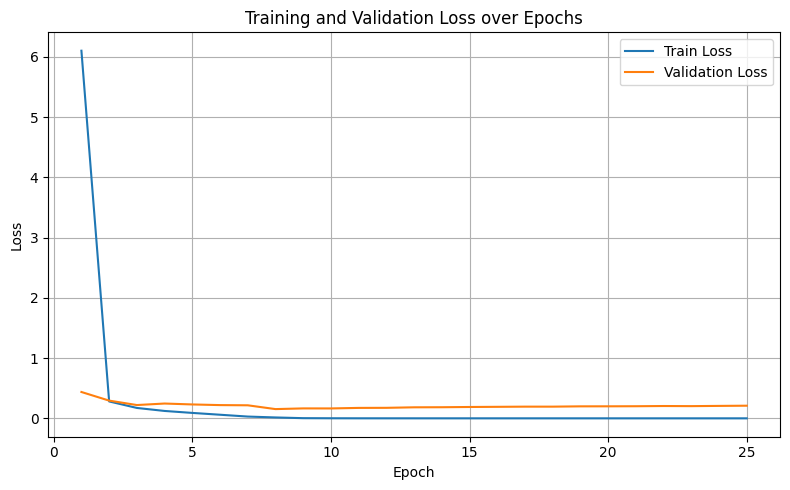

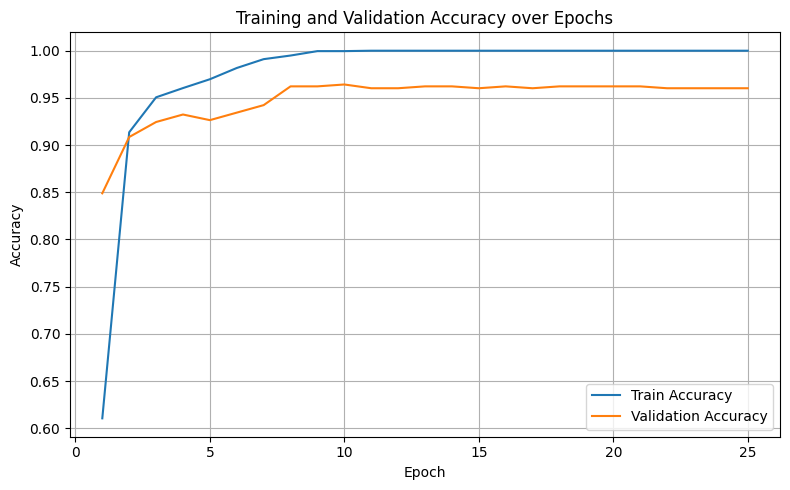

In [ ]:
# 5) Model Definition
class SimpleToneCNN(nn.Module):
    def __init__(self, n_cls=len(label_names)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*16*56,128), nn.ReLU(),
            nn.Linear(128,n_cls)
        )
    def forward(self,x):
        return self.net(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = SimpleToneCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 6) Training Loop (25 epochs), with metric tracking
num_epochs = 25

# Prepare lists to hold per‐epoch metrics
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(num_epochs):
    ### --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct      = 0
    total        = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out   = model(xb)
        loss  = criterion(out, yb)
        loss.backward()
        optimizer.step()

        # Accumulate loss * batch_size (so we can compute average later)
        running_loss += loss.item() * xb.size(0)

        # Compute training‐batch accuracy
        preds   = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

    # At epoch end, compute average train loss & accuracy
    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)


    ### --- Validation Phase ---
    model.eval()
    v_running_loss = 0.0
    v_correct      = 0
    v_total        = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out    = model(xb)
            loss   = criterion(out, yb)

            v_running_loss += loss.item() * xb.size(0)
            preds         = out.argmax(dim=1)
            v_correct    += (preds == yb).sum().item()
            v_total      += yb.size(0)

    epoch_val_loss = v_running_loss / v_total
    epoch_val_acc  = v_correct / v_total

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)


    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f} | "
          f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.3f}")

# At the end of training you have:
#   train_losses, train_accs, val_losses, val_accs
print("✅ Finished training. Collected metrics for each epoch.")

epochs = range(1, num_epochs + 1)

# 1) Loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install torchinfo

In [ ]:
# 1. Simple printout (PyTorch default)
print(model)

# 2. Use torchinfo (formerly torchsummary) for a layer-by-layer summary:
#    pip install torchinfo   (if not already installed)
from torchinfo import summary

# Assuming input spectrograms are 1×64×224:
summary(model, input_size=(1, 1, 64, 224))

# 3. Alternatively, using torchsummary directly:
#    pip install torchsummary  (if needed)
from torchsummary import summary as ts_summary
ts_summary(model, input_size=(1, 64, 224), batch_size=1)

# 4. Show total number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


SimpleToneCNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=28672, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=6, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 16, 64, 224]             416
              ReLU-2           [1, 16, 64, 224]               0
         MaxPool2d-3           [1, 16, 32, 112]               0
            Conv2d-4           [1, 32, 32, 112]           4,640
              ReLU-5           [1, 32, 32,

In [ ]:
# Cell 4: Collect predictions on the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:    # assumes test_loader is defined as in your training script
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")
# Cell 5: Full classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))


Test Accuracy: 0.9584
Classification Report:
              precision    recall  f1-score   support

       huyền       0.95      0.97      0.96        65
         hỏi       0.97      0.97      0.97        74
       ngang       1.00      0.97      0.98        86
         ngã       0.97      0.94      0.95        78
        nặng       0.96      0.94      0.95       103
         sắc       0.91      0.97      0.94        99

    accuracy                           0.96       505
   macro avg       0.96      0.96      0.96       505
weighted avg       0.96      0.96      0.96       505



In [ ]:
# Cell 6: Plot normalized confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:,None]

plot_confusion_matrix(cm,  label_names, "Confusion Matrix: Synthetic Data")

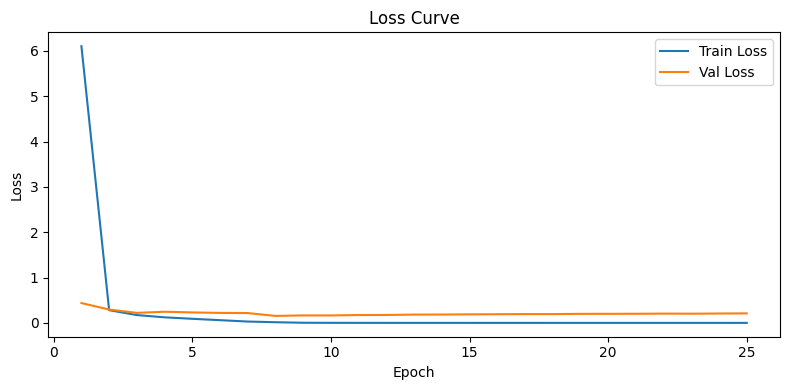

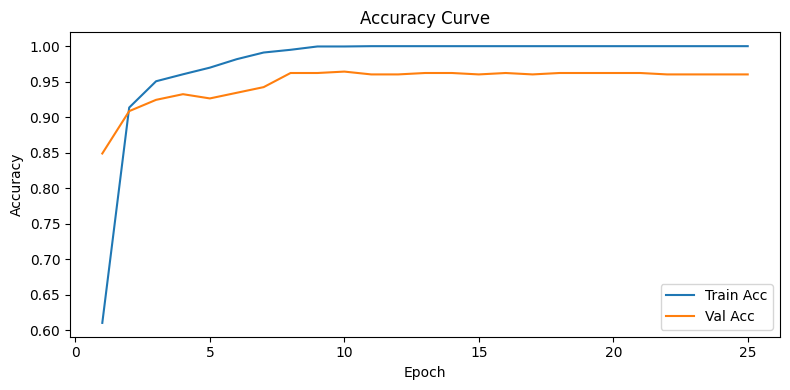

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs+1))

plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model_name      = "simple_tone_cnn_combined_large_pkg"

# 1) Save metrics
metrics_filename = f"{local_data_root}{model_name}_metrics.csv"
df_metrics = pd.DataFrame({
    "epoch":      list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "train_acc":  train_accs,
    "val_loss":   val_losses,
    "val_acc":    val_accs,
})
df_metrics.to_csv(metrics_filename, index=False)
print(f"✅ Metrics saved to {metrics_filename}")

# 2) Save model weights
weights_filename = f"{local_data_root}{model_name}.pth"
torch.save(model.state_dict(), weights_filename)
print(f"✅ Weights saved to {weights_filename}")

✅ Metrics saved to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/simple_tone_cnn_combined_large_pkg_metrics.csv
✅ Weights saved to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/simple_tone_cnn_combined_large_pkg.pth


In [ ]:
model_names = ["simple_tone_cnn_synth_small_pkg","simple_tone_cnn_synth_large_pkg", "simple_tone_cnn_real_pkg",
               "simple_tone_cnn_combined_small_pkg", "simple_tone_cnn_combined_large_pkg"]

In [9]:
# Cell 5: Evaluation function
def evaluate(loader, name, model):
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"\n— {name} Set —")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,  label_names, f"Confusion Matrix: {name}")

## Results

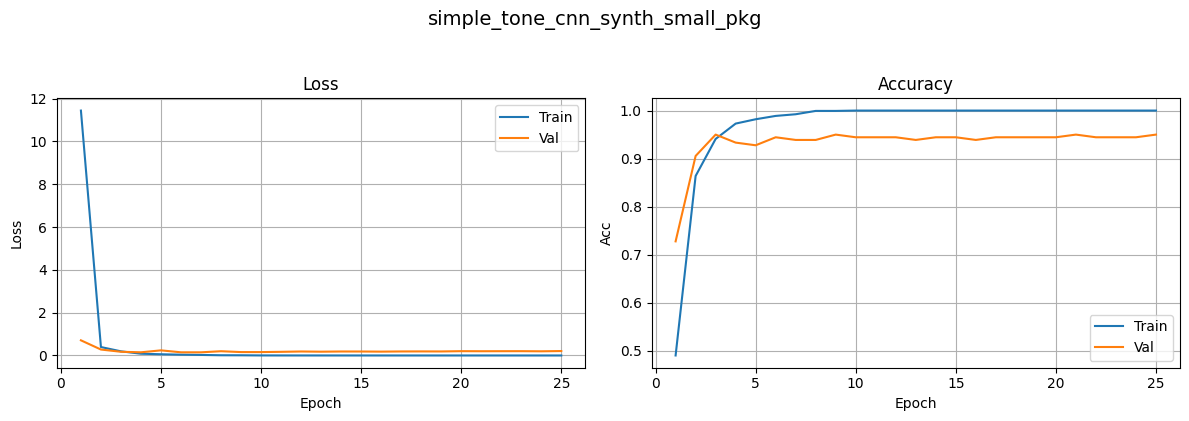

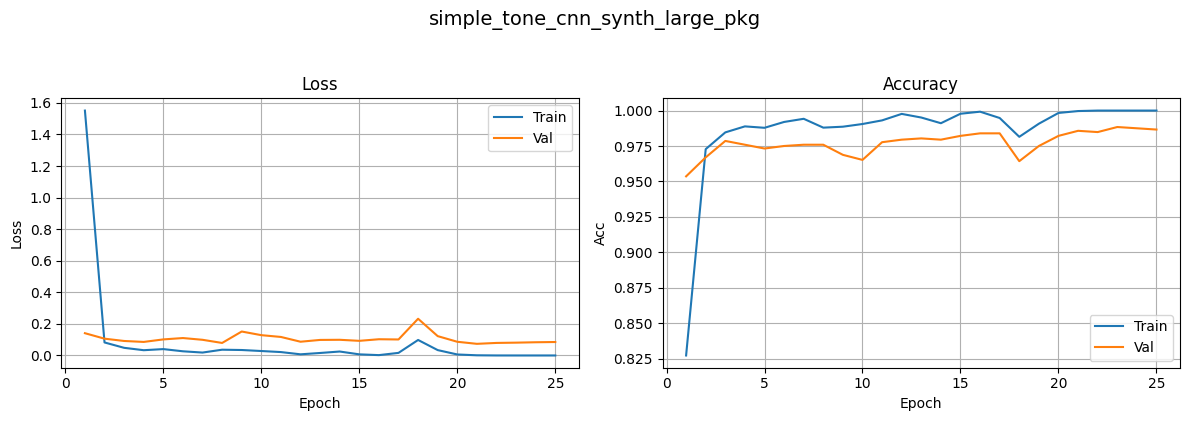

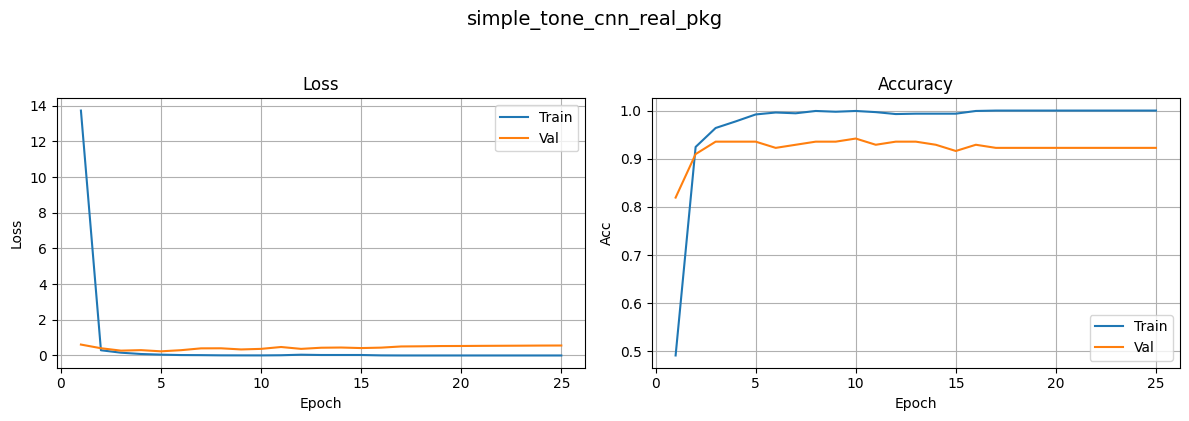

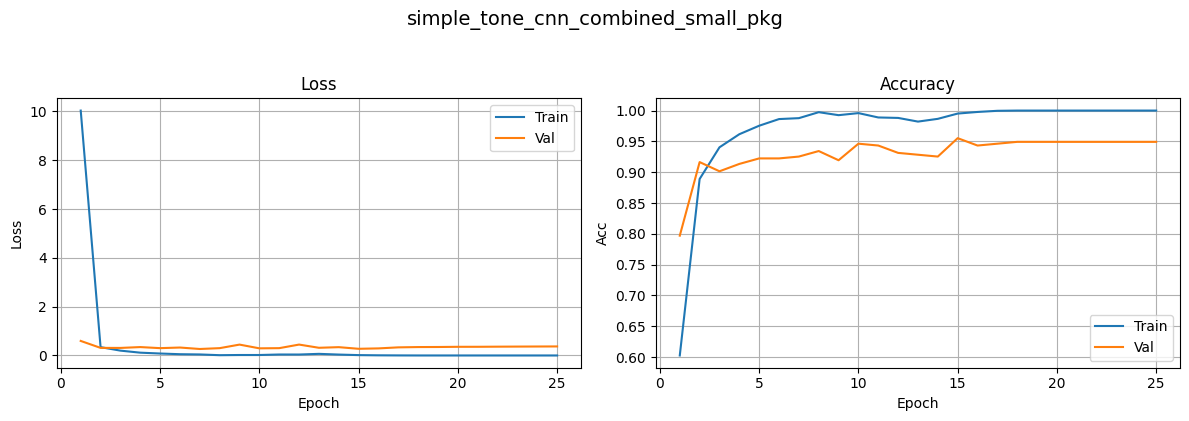

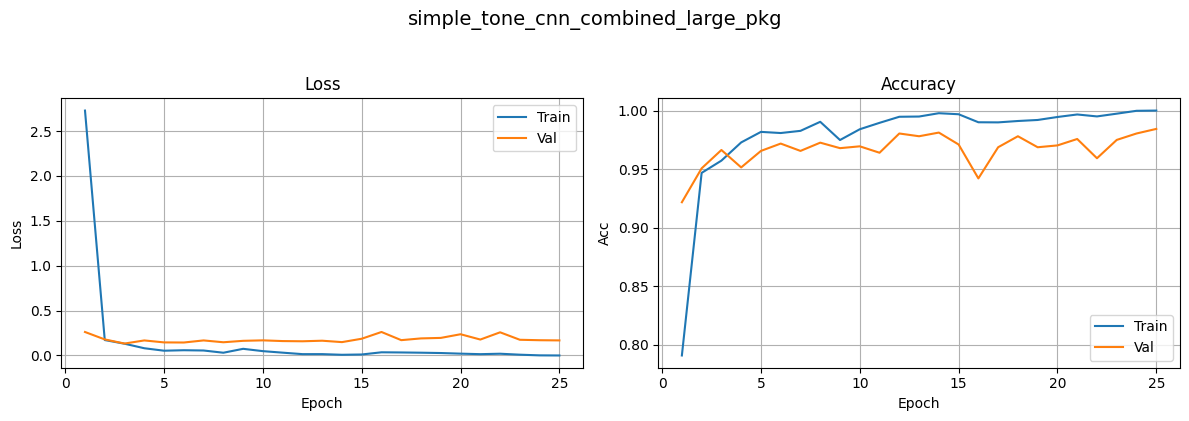


===  Validation-set snapshot  ===


,model,best_val_acc,best_epoch,final_val_acc,final_train_acc
0,simple_tone_cnn_synth_large_pkg,0.988,23,0.987,1.000
1,simple_tone_cnn_combined_large_pkg,0.984,25,0.984,1.000
2,simple_tone_cnn_combined_small_pkg,0.955,15,0.949,1.000
3,simple_tone_cnn_synth_small_pkg,0.950,3,0.950,1.000
4,simple_tone_cnn_real_pkg,0.942,10,0.923,1.000


In [ ]:
# %%  Plot learning curves and summarise metrics for every checkpoint ________
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# ---------------------------------------------------------------------------
# 0)  CONFIGURATION
# ---------------------------------------------------------------------------
root = Path("/content/drive/MyDrive/UPF_Deep_Learning_2025/Project")

model_names = [
    "simple_tone_cnn_synth_small_pkg",
    "simple_tone_cnn_synth_large_pkg",
    "simple_tone_cnn_real_pkg",
    "simple_tone_cnn_combined_small_pkg",
    "simple_tone_cnn_combined_large_pkg",
]

# ---------------------------------------------------------------------------
# 1)  Containers for a final comparison table
# ---------------------------------------------------------------------------
summary_rows = []

# ---------------------------------------------------------------------------
# 2)  Loop over every metrics CSV
# ---------------------------------------------------------------------------
for mname in model_names:
    csv_path = root / f"{mname}_metrics.csv"
    if not csv_path.exists():
        print(f"⛔  {csv_path.name} not found – skipping\n")
        continue

    # ---- 2.1  Read CSV -----------------------------------------------------
    df = pd.read_csv(csv_path)
    epochs     = df["epoch"]
    train_loss = df["train_loss"]
    val_loss   = df["val_loss"]
    train_acc  = df["train_acc"]
    val_acc    = df["val_acc"]

    # ---- 2.2  Plot curves --------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    ax[0].plot(epochs, train_loss, label="Train")
    ax[0].plot(epochs, val_loss,   label="Val")
    ax[0].set_title("Loss");  ax[0].set_xlabel("Epoch");  ax[0].set_ylabel("Loss")
    ax[0].legend();  ax[0].grid(True)

    # Accuracy curve
    ax[1].plot(epochs, train_acc, label="Train")
    ax[1].plot(epochs, val_acc,   label="Val")
    ax[1].set_title("Accuracy");  ax[1].set_xlabel("Epoch");  ax[1].set_ylabel("Acc")
    ax[1].legend();  ax[1].grid(True)

    plt.suptitle(mname, y=1.04, fontsize=14)
    plt.tight_layout();  plt.show()

    # ---- 2.3  Add to summary ---------------------------------------------
    best_idx   = val_acc.idxmax()
    summary_rows.append({
        "model"          : mname,
        "best_val_acc"   : val_acc[best_idx],
        "best_epoch"     : int(epochs[best_idx]),
        "final_val_acc"  : val_acc.iloc[-1],
        "final_train_acc": train_acc.iloc[-1]
    })

# ---------------------------------------------------------------------------
# 3)  Display summary table
# ---------------------------------------------------------------------------
df_summary = (pd.DataFrame(summary_rows)
              .sort_values("best_val_acc", ascending=False)
              .reset_index(drop=True))

print("\n===  Validation-set snapshot  ===")
display(df_summary.style.format({
    "best_val_acc"  : "{:.3f}",
    "final_val_acc" : "{:.3f}",
    "final_train_acc": "{:.3f}"
}))


## Data Augmentation

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import numpy as np
import cv2
import random

# ── 1) SpecAugment helper ───────────────────────────────────────────────────
# This code is adapted from the popular SpecAugment repository
# https://github.com/pyyush/SpecAugment
def spec_augment(spec: np.ndarray,
                 time_mask_pct: float = 0.10,
                 freq_mask_pct: float = 0.10) -> np.ndarray:
    H, W = spec.shape
    # Frequency mask
    n_freq = int(H * freq_mask_pct)
    if n_freq > 0:
        f0 = random.randint(0, H - n_freq)
        spec[f0 : f0 + n_freq, :] = -80.0

    # Time mask
    n_time = int(W * time_mask_pct)
    if n_time > 0:
        t0 = random.randint(0, W - n_time)
        spec[:, t0 : t0 + n_time] = -80.0

    return spec

# ── 2) Wrap (X,y) into a Dataset that applies augmentation only when desired ─
class AugmentedMelDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, augment: bool = False):
        """
        X: torch.FloatTensor of shape (N, 1, 64, 225)  in log-dB already.
        y: torch.LongTensor of shape (N,)
        If augment=True, each sample’s (64×225) mel will be masked 50% of the time.
        """
        assert X.ndim == 4 and X.shape[1] == 1 and X.shape[2] == 64 and X.shape[3] == 225
        self.X = X
        self.y = y
        self.N = X.shape[0]
        self.augment = augment

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        # 1) Extract single-channel mel: shape (64,225)
        spec_db = self.X[idx, 0].cpu().numpy().copy()  # convert to NumPy so we can mask

        # 2) Apply SpecAugment 50% of the time if augment=True
        if self.augment and random.random() < 0.5:
            spec_db = spec_augment(spec_db,
                                   time_mask_pct=0.3,
                                   freq_mask_pct=0.3)

        # 3) Convert back to a PyTorch tensor, shape (1,64,225)
        x = torch.from_numpy(spec_db.astype(np.float32)).unsqueeze(0)

        # 4) Label tensor
        y = torch.tensor(int(self.y[idx].item()), dtype=torch.long)
        return x, y

# ── 3) Load your packed X_full.npy / y_full.npy as tensors ─────────────────

X_full = np.load(f"{combined_pkg_large}/X_full.npy")   # (N,1,64,225)
y_full = np.load(f"{combined_pkg_large}/y_full.npy")   # (N,)
label_names = json.load(open(f"{combined_pkg_large}/label_names.json", "r", encoding="utf-8"))

# Convert to PyTorch tensors once
X_tensor = torch.tensor(X_full, dtype=torch.float32)   # shape (N,1,64,225)
y_tensor = torch.tensor(y_full, dtype=torch.long)      # shape (N,)

# ── 4) Build a single Dataset instance (un-augmented by default) ────────────
#     We will split indices, then wrap subsets in AugmentedMelDataset with different flags.
base_dataset = TensorDataset(X_tensor, y_tensor)

# ── 5) Compute train/val/test sizes and split the indices ───────────────────
N       = len(base_dataset)
train_n = int(0.8 * N)
val_n   = int(0.1 * N)
test_n  = N - train_n - val_n

train_indices, val_indices, test_indices = random_split(
    list(range(N)), [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

# ── 6) Create three Dataset objects:
#      - train_ds with augment=True
#      - val_ds & test_ds with augment=False
train_ds = torch.utils.data.Subset(
    AugmentedMelDataset(X_tensor, y_tensor, augment=False),
    train_indices
)
val_ds   = torch.utils.data.Subset(
    AugmentedMelDataset(X_tensor, y_tensor, augment=False),
    val_indices
)
test_ds  = torch.utils.data.Subset(
    AugmentedMelDataset(X_tensor, y_tensor, augment=False),
    test_indices
)

# ── 7) Build DataLoaders ─────────────────────────────────────────────────────
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, pin_memory=True)

print(f"Train  samples: {len(train_ds)}  (with augmentation enabled)")
print(f"Val    samples: {len(val_ds)}   (no augmentation)")
print(f"Test   samples: {len(test_ds)}  (no augmentation)")


Train  samples: 10219  (with augmentation enabled)
Val    samples: 1277   (no augmentation)
Test   samples: 1278  (no augmentation)


In [12]:
# ── 8) Define your model, optimizer, and loss as before ────────────────────
class SimpleToneCNN(nn.Module):
    def __init__(self, n_cls=len(label_names)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*16*56,128), nn.ReLU(),
            nn.Linear(128,n_cls)
        )
    def forward(self,x):
        return self.net(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = SimpleToneCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ── 9) Training Loop (30 epochs), with per-epoch tracking ──────────────────
num_epochs = 25

train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(num_epochs):
    ### --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct      = 0
    total        = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out   = model(xb)
        loss  = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds        = out.argmax(dim=1)
        correct     += (preds == yb).sum().item()
        total       += yb.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    ### --- Validation Phase ---
    model.eval()
    v_running_loss = 0.0
    v_correct      = 0
    v_total        = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out    = model(xb)
            loss   = criterion(out, yb)

            v_running_loss += loss.item() * xb.size(0)
            preds         = out.argmax(dim=1)
            v_correct    += (preds == yb).sum().item()
            v_total      += yb.size(0)

    epoch_val_loss = v_running_loss / v_total
    epoch_val_acc  = v_correct / v_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f} | "
          f"Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.3f}")

print("✅ Finished training with SpecAugment on the train split.")


Epoch  1 | Train Loss: 1.6921, Train Acc: 0.828 | Val   Loss: 0.1779, Val   Acc: 0.943
Epoch  2 | Train Loss: 0.1106, Train Acc: 0.967 | Val   Loss: 0.0972, Val   Acc: 0.970
Epoch  3 | Train Loss: 0.0662, Train Acc: 0.979 | Val   Loss: 0.1221, Val   Acc: 0.972
Epoch  4 | Train Loss: 0.0417, Train Acc: 0.989 | Val   Loss: 0.1079, Val   Acc: 0.974
Epoch  5 | Train Loss: 0.0224, Train Acc: 0.993 | Val   Loss: 0.0915, Val   Acc: 0.977
Epoch  6 | Train Loss: 0.0163, Train Acc: 0.995 | Val   Loss: 0.1657, Val   Acc: 0.958
Epoch  7 | Train Loss: 0.0385, Train Acc: 0.986 | Val   Loss: 0.1240, Val   Acc: 0.971
Epoch  8 | Train Loss: 0.0258, Train Acc: 0.991 | Val   Loss: 0.0857, Val   Acc: 0.984
Epoch  9 | Train Loss: 0.0072, Train Acc: 0.997 | Val   Loss: 0.1257, Val   Acc: 0.978
Epoch 10 | Train Loss: 0.0221, Train Acc: 0.992 | Val   Loss: 0.1235, Val   Acc: 0.978
Epoch 11 | Train Loss: 0.0104, Train Acc: 0.997 | Val   Loss: 0.1164, Val   Acc: 0.984
Epoch 12 | Train Loss: 0.0006, Train Acc: 1

✅ Label names match between training data and Forvo data.

Evaluating on Forvo Dataset:

— Forvo Set —
Accuracy: 0.6538

Classification Report:
              precision    recall  f1-score   support

       huyền       0.50      0.12      0.20         8
         hỏi       0.60      0.43      0.50         7
       ngang       1.00      0.92      0.96        12
         ngã       0.57      0.80      0.67         5
        nặng       0.45      0.71      0.56         7
         sắc       0.62      0.77      0.69        13

    accuracy                           0.65        52
   macro avg       0.63      0.63      0.59        52
weighted avg       0.66      0.65      0.63        52



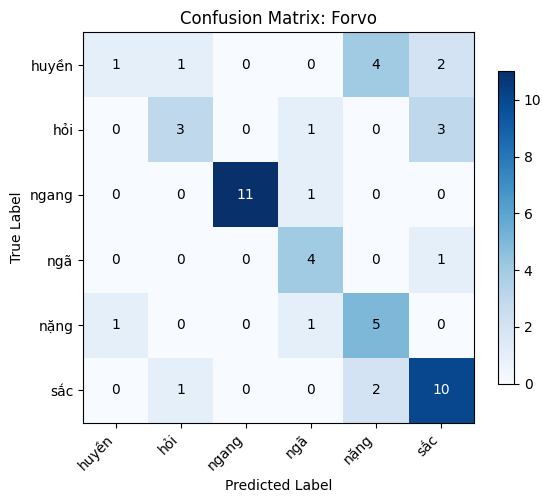

In [13]:
# prompt: test on the forvo data

import numpy as np
# Forvo data location
forvo_pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/forvo_syllables"

# Load Forvo Dataset
X_forvo = np.load(f"{forvo_pkg}/X.npy")           # (N, 1, 64, 225)
y_forvo = np.load(f"{forvo_pkg}/y.npy")           # (N,)

with open(f"{forvo_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names_forvo = json.load(f)

# Convert to PyTorch tensors
X_forvo_tensor = torch.tensor(X_forvo, dtype=torch.float32)
y_forvo_tensor = torch.tensor(y_forvo, dtype=torch.long)
forvo_dataset = TensorDataset(X_forvo_tensor, y_forvo_tensor)

# Create DataLoader for Forvo dataset
forvo_loader = DataLoader(forvo_dataset, batch_size=64, shuffle=False)

# Ensure label names match between the trained model and Forvo data
# This is crucial for the classification report
assert label_names == label_names_forvo, "⚠️ Label names mismatch between training data and Forvo data!"
print("✅ Label names match between training data and Forvo data.")

# Evaluate the trained model on the Forvo dataset
print("\nEvaluating on Forvo Dataset:")
evaluate(forvo_loader, "Forvo", model)

## Training mixed and evaluating in separate sets

In [ ]:
# 1) Split synth-only vs. real-only

# Load Synth
X_synth = np.load(f"{synth_large_pkg_dir}/X.npy")
y_synth = np.load(f"{synth_large_pkg_dir}/y.npy")

# Load Real (drill)
X_real = np.load(f"{drill_pkg}/drill_X.npy")
y_real = np.load(f"{drill_pkg}/drill_y.npy")

# 2) Split synth into train/val/test (e.g. 80/10/10)
synth_X_temp, synth_X_test, synth_y_temp, synth_y_test = train_test_split(
    X_synth, y_synth, test_size=0.1, random_state=42, stratify=y_synth
)
synth_X_train, synth_X_val, synth_y_train, synth_y_val = train_test_split(
    synth_X_temp, synth_y_temp, test_size=0.1111,  # 0.1111 * 0.9 ≈ 0.10 total
    random_state=42, stratify=synth_y_temp
)

# 3) Split real into train/val/test (same ratio)
real_X_temp, real_X_test, real_y_temp, real_y_test = train_test_split(
    X_real, y_real, test_size=0.1, random_state=42, stratify=y_real
)
real_X_train, real_X_val, real_y_train, real_y_val = train_test_split(
    real_X_temp, real_y_temp, test_size=0.1111, random_state=42, stratify=real_y_temp
)

# 4) Wrap each split in a TensorDataset (with correct dtype keywords)
ds_synth_train = TensorDataset(
    torch.tensor(synth_X_train, dtype=torch.float32),
    torch.tensor(synth_y_train, dtype=torch.long)
)
ds_synth_val = TensorDataset(
    torch.tensor(synth_X_val, dtype=torch.float32),
    torch.tensor(synth_y_val, dtype=torch.long)
)
ds_synth_test = TensorDataset(
    torch.tensor(synth_X_test, dtype=torch.float32),
    torch.tensor(synth_y_test, dtype=torch.long)
)

ds_real_train = TensorDataset(
    torch.tensor(real_X_train, dtype=torch.float32),
    torch.tensor(real_y_train, dtype=torch.long)
)
ds_real_val = TensorDataset(
    torch.tensor(real_X_val, dtype=torch.float32),
    torch.tensor(real_y_val, dtype=torch.long)
)
ds_real_test = TensorDataset(
    torch.tensor(real_X_test, dtype=torch.float32),
    torch.tensor(real_y_test, dtype=torch.long)
)

# 5) Combine train folds and create DataLoaders
train_ds = torch.utils.data.ConcatDataset([ds_synth_train, ds_real_train])
val_ds = torch.utils.data.ConcatDataset([ds_synth_val, ds_real_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

loader_synth_test = DataLoader(ds_synth_test, batch_size=64, shuffle=False)
loader_real_test = DataLoader(ds_real_test, batch_size=64, shuffle=False)


In [ ]:
# 5) Model Definition
class SimpleToneCNN(nn.Module):
    def __init__(self, n_cls=len(label_names)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*16*56,128), nn.ReLU(),
            nn.Linear(128,n_cls)
        )
    def forward(self,x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleToneCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 6) Training Loop (10 epochs)
for epoch in range(25):
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    train_acc = correct / total

    # Validate
    model.eval()
    v_correct, v_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1)
            v_correct += (preds == yb).sum().item()
            v_total += yb.size(0)
    val_acc = v_correct / v_total

    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

Epoch 1: train_acc=0.858, val_acc=0.923
Epoch 2: train_acc=0.970, val_acc=0.967
Epoch 3: train_acc=0.983, val_acc=0.978
Epoch 4: train_acc=0.990, val_acc=0.955
Epoch 5: train_acc=0.989, val_acc=0.981
Epoch 6: train_acc=0.992, val_acc=0.982
Epoch 7: train_acc=0.993, val_acc=0.979
Epoch 8: train_acc=0.993, val_acc=0.978
Epoch 9: train_acc=0.994, val_acc=0.969
Epoch 10: train_acc=0.995, val_acc=0.978
Epoch 11: train_acc=0.994, val_acc=0.953
Epoch 12: train_acc=0.994, val_acc=0.969
Epoch 13: train_acc=0.989, val_acc=0.975
Epoch 14: train_acc=0.998, val_acc=0.978
Epoch 15: train_acc=1.000, val_acc=0.980
Epoch 16: train_acc=1.000, val_acc=0.979
Epoch 17: train_acc=1.000, val_acc=0.980
Epoch 18: train_acc=1.000, val_acc=0.980
Epoch 19: train_acc=1.000, val_acc=0.979
Epoch 20: train_acc=1.000, val_acc=0.979
Epoch 21: train_acc=1.000, val_acc=0.979
Epoch 22: train_acc=1.000, val_acc=0.979
Epoch 23: train_acc=1.000, val_acc=0.980
Epoch 24: train_acc=1.000, val_acc=0.980
Epoch 25: train_acc=1.000


— Real Voices Set —
Accuracy: 0.9359

Classification Report:
              precision    recall  f1-score   support

       huyền       0.92      1.00      0.96        22
         hỏi       0.94      0.89      0.92        19
       ngang       0.95      0.88      0.91        24
         ngã       0.94      1.00      0.97        16
        nặng       0.87      0.89      0.88        37
         sắc       1.00      0.97      0.99        38

    accuracy                           0.94       156
   macro avg       0.94      0.94      0.94       156
weighted avg       0.94      0.94      0.94       156



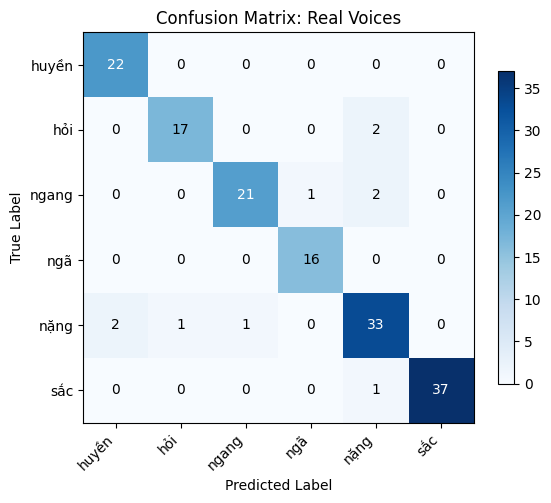


— Synthetic Data Set —
Accuracy: 0.9875

Classification Report:
              precision    recall  f1-score   support

       huyền       0.99      0.99      0.99       187
         hỏi       0.99      0.99      0.99       186
       ngang       1.00      0.98      0.99       187
         ngã       0.99      0.99      0.99       188
        nặng       0.98      0.98      0.98       187
         sắc       0.98      0.99      0.98       187

    accuracy                           0.99      1122
   macro avg       0.99      0.99      0.99      1122
weighted avg       0.99      0.99      0.99      1122



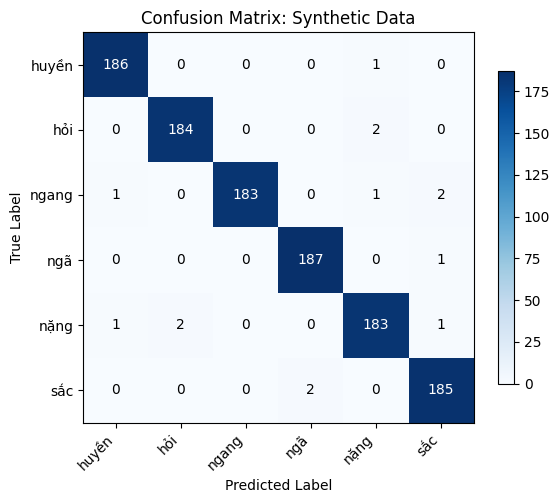

In [ ]:
# Cell 6: Run on real and synthetic
evaluate(loader_real_test,  "Real Voices", model)
evaluate(loader_synth_test, "Synthetic Data", model)


— Real Voices Forvo Set —
Accuracy: 0.5769

Classification Report:
              precision    recall  f1-score   support

       huyền       0.00      0.00      0.00         8
         hỏi       0.50      0.29      0.36         7
       ngang       1.00      0.83      0.91        12
         ngã       1.00      0.20      0.33         5
        nặng       0.46      0.86      0.60         7
         sắc       0.55      0.85      0.67        13

    accuracy                           0.58        52
   macro avg       0.59      0.50      0.48        52
weighted avg       0.59      0.58      0.54        52



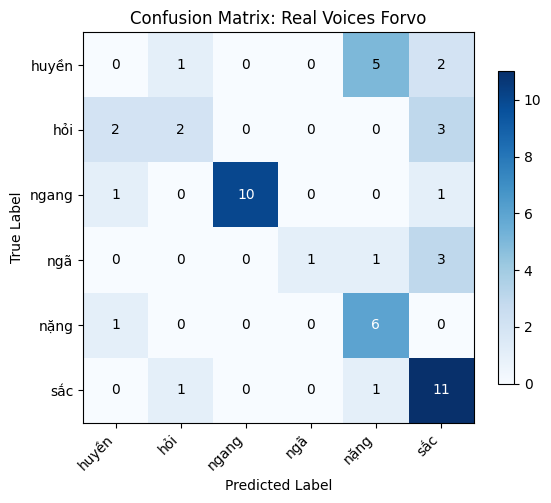

In [ ]:
X_forvo = np.load(f"{forvo_pkg}/X.npy")    # (N_synth, 1, 64, 225)
y_forvo = np.load(f"{forvo_pkg}/y.npy")    # (N_synth,)

# 4) Wrap each split in TensorDataset
ds_forvo = TensorDataset(
    torch.tensor(X_forvo, dtype=torch.float32),
    torch.tensor(y_forvo, dtype=torch.long)
)

forvo_test_loader       = DataLoader(ds_forvo, batch_size=64, shuffle=False, pin_memory=True)

evaluate(forvo_test_loader, "Real Voices Forvo", model)

## Fine-Tuning Wav2Vec2

In [ ]:
# ──────────────────────────────────────────────────────────
#  Wav2Vec2 Fine‐Tune from Folder (no CSV needed)
# ──────────────────────────────────────────────────────────

from glob import glob
import os, json, unicodedata
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
from sklearn.metrics import classification_report, confusion_matrix

# 1) Paths & Settings
DRIVE_ROOT   = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project"
WAV_FOLDER   = os.path.join(DRIVE_ROOT, "output_drills")
LABEL_JSON   = os.path.join(DRIVE_ROOT, "subset_package/label_names.json")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SR, MAX_LEN  = 16000, 16000   # 1s clips or pad/truncate to 1s

# 2) Load label_names.json
with open(LABEL_JSON, "r", encoding="utf-8") as f:
    label_names = json.load(f)
label_to_idx = {t:i for i,t in enumerate(label_names)}

# 3) Tone extractor (from filename)
tone_map = {
  "\u0300":"huyền","\u0301":"sắc","\u0303":"ngã",
  "\u0309":"hỏi","\u0323":"nặng"
}
def extract_tone(syll):
    for ch in unicodedata.normalize("NFD", syll):
        if ch in tone_map: return tone_map[ch]
    return "ngang"

# 4) Build list of (wav_path, label_idx)
all_wavs = sorted(glob(os.path.join(WAV_FOLDER, "*.wav")))
pairs = []
for wav in all_wavs:
    name = os.path.basename(wav)
    # filename format: "0000_ma.wav" or "0001_mà.wav"
    syl = name.split("_",1)[1].rsplit(".",1)[0]
    tone = extract_tone(syl)
    idx  = label_to_idx[tone]
    pairs.append((wav, idx))

# 5) Prepare Wav2Vec2 processor & base model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
for p in base_model.parameters(): p.requires_grad = False

# 6) Define classifier head
class W2V2ToneClassifier(nn.Module):
    def __init__(self, base, num_labels):
        super().__init__()
        self.base = base
        self.head = nn.Sequential(
            nn.Linear(base.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
    def forward(self, x):
        out = self.base(x).last_hidden_state  # (B,T,D)
        pooled = out.mean(dim=1)             # (B,D)
        return self.head(pooled)

model = W2V2ToneClassifier(base_model, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-4)

# 7) Dataset from folder
class FolderWavDataset(Dataset):
    def __init__(self, pairs, processor, sr=SR, max_len=MAX_LEN):
        self.pairs = pairs
        self.processor = processor
        self.sr = sr
        self.max_len = max_len
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        path, label = self.pairs[i]
        y,_ = librosa.load(path, sr=self.sr)
        # pad/trim
        if len(y)<self.max_len:
            y = np.pad(y, (0,self.max_len-len(y)))
        else:
            y = y[:self.max_len]
        inputs = self.processor(y, sampling_rate=self.sr, return_tensors="pt")
        x = inputs.input_values.squeeze(0)  # (max_len,)
        return x, torch.tensor(label, dtype=torch.long)

dataset = FolderWavDataset(pairs, processor)

# 8) Train/Val/Test split
N = len(dataset)
train_n = int(0.8*N)
val_n   = int(0.1*N)
test_n  = N - train_n - val_n
train_ds, val_ds, test_ds = random_split(
    dataset, [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

# 9) Fine‐tune for 5 epochs
for epoch in range(5):
    model.train()
    tot, corr = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(1)
        corr += (preds==yb).sum().item()
        tot  += yb.size(0)
    train_acc = corr/tot

    model.eval()
    v_tot, v_corr = 0, 0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb).argmax(1)
            v_corr += (preds==yb).sum().item()
            v_tot  += yb.size(0)
    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={v_corr/v_tot:.3f}")

# 10) Test report
model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for xb,yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb).cpu().argmax(1)
        all_p.extend(out.tolist())
        all_t.extend(yb.tolist())

print(classification_report(all_t, all_p, target_names=label_names))
print(confusion_matrix(all_t, all_p))


In [ ]:
model = W2V2ToneClassifier(base_model, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-4)
for epoch in range(50):
    model.train()
    tot, corr = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(1)
        corr += (preds==yb).sum().item()
        tot  += yb.size(0)
    train_acc = corr/tot

    model.eval()
    v_tot, v_corr = 0, 0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb).argmax(1)
            v_corr += (preds==yb).sum().item()
            v_tot  += yb.size(0)
    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={v_corr/v_tot:.3f}")

# 10) Test report
model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for xb,yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb).cpu().argmax(1)
        all_p.extend(out.tolist())
        all_t.extend(yb.tolist())

print(classification_report(all_t, all_p, target_names=label_names))
print(confusion_matrix(all_t, all_p))

Epoch 1: train_acc=0.349, val_acc=0.247
Epoch 2: train_acc=0.455, val_acc=0.264
Epoch 3: train_acc=0.507, val_acc=0.286
Epoch 4: train_acc=0.571, val_acc=0.352
Epoch 5: train_acc=0.585, val_acc=0.388
Epoch 6: train_acc=0.625, val_acc=0.335
Epoch 7: train_acc=0.639, val_acc=0.366
Epoch 8: train_acc=0.649, val_acc=0.374
Epoch 9: train_acc=0.658, val_acc=0.401
Epoch 10: train_acc=0.684, val_acc=0.388
Epoch 11: train_acc=0.696, val_acc=0.383
Epoch 12: train_acc=0.690, val_acc=0.419
Epoch 13: train_acc=0.732, val_acc=0.374
Epoch 14: train_acc=0.718, val_acc=0.383
Epoch 15: train_acc=0.721, val_acc=0.410
Epoch 16: train_acc=0.745, val_acc=0.436
Epoch 17: train_acc=0.752, val_acc=0.445
Epoch 18: train_acc=0.757, val_acc=0.445
Epoch 19: train_acc=0.761, val_acc=0.445
Epoch 20: train_acc=0.763, val_acc=0.441
Epoch 21: train_acc=0.770, val_acc=0.441
Epoch 22: train_acc=0.781, val_acc=0.432
Epoch 23: train_acc=0.759, val_acc=0.458
Epoch 24: train_acc=0.780, val_acc=0.414
Epoch 25: train_acc=0.794

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1/50  –  train_acc=0.3527,  val_acc=0.2070
Epoch 2/50  –  train_acc=0.4571,  val_acc=0.2555
Epoch 3/50  –  train_acc=0.5412,  val_acc=0.3128
Epoch 4/50  –  train_acc=0.5676,  val_acc=0.3877
Epoch 5/50  –  train_acc=0.5973,  val_acc=0.3833
Epoch 6/50  –  train_acc=0.6357,  val_acc=0.3700
Epoch 7/50  –  train_acc=0.6473,  val_acc=0.3480
Epoch 8/50  –  train_acc=0.6527,  val_acc=0.3965
Epoch 9/50  –  train_acc=0.6687,  val_acc=0.4405
Epoch 10/50  –  train_acc=0.6951,  val_acc=0.4097
Epoch 11/50  –  train_acc=0.7033,  val_acc=0.3965
Epoch 12/50  –  train_acc=0.7121,  val_acc=0.4097
Epoch 13/50  –  train_acc=0.7242,  val_acc=0.4758
Epoch 14/50  –  train_acc=0.7390,  val_acc=0.4670
Epoch 15/50  –  train_acc=0.7269,  val_acc=0.4537
Epoch 16/50  –  train_acc=0.7451,  val_acc=0.4670
Epoch 17/50  –  train_acc=0.7429,  val_acc=0.4317
Epoch 18/50  –  train_acc=0.7401,  val_acc=0.4537
Epoch 19/50  –  train_acc=0.7604,  val_acc=0.4890
Epoch 20/50  –  train_acc=0.7593,  val_acc=0.4846
Epoch 21/

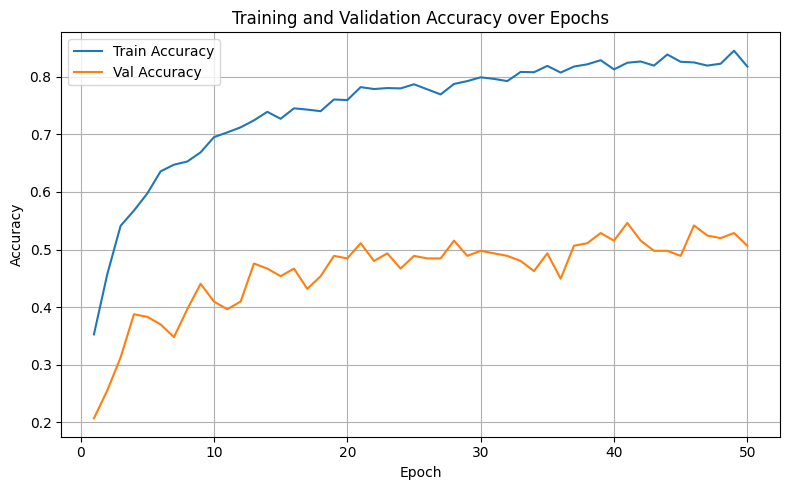

              precision    recall  f1-score   support

       huyền       0.57      0.45      0.50        38
         hỏi       1.00      0.37      0.54        27
       ngang       0.76      0.64      0.70        50
         ngã       0.71      0.62      0.67        24
        nặng       0.43      0.81      0.56        43
         sắc       0.58      0.55      0.57        47

    accuracy                           0.59       229
   macro avg       0.68      0.57      0.59       229
weighted avg       0.65      0.59      0.59       229



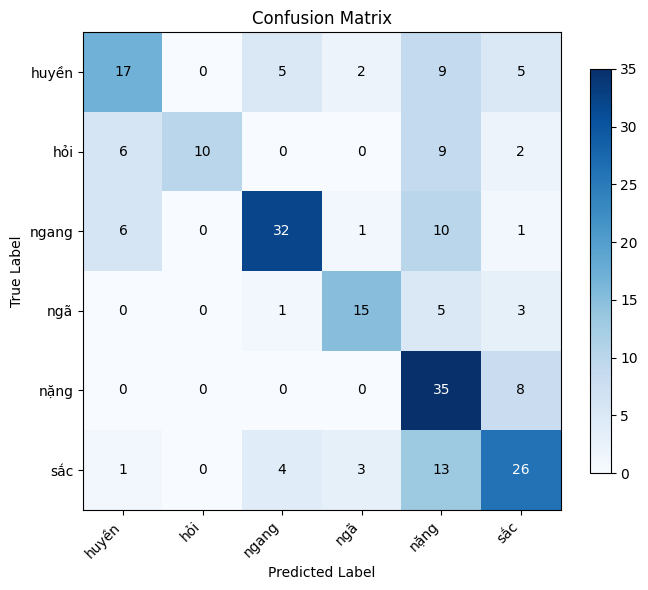

In [ ]:
import os, json, unicodedata
from glob import glob
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Paths & Settings
DRIVE_ROOT   = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project"
WAV_FOLDER   = os.path.join(DRIVE_ROOT, "output_drills")
LABEL_JSON   = os.path.join(DRIVE_ROOT, "subset_package_small/label_names.json")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SR, MAX_LEN  = 16000, 16000   # 1s clips or pad/truncate to 1s

# 2) Load label_names.json
with open(LABEL_JSON, "r", encoding="utf-8") as f:
    label_names = json.load(f)
label_to_idx = {t:i for i,t in enumerate(label_names)}

# 3) Tone extractor (from filename)
tone_map = {
  "\u0300":"huyền","\u0301":"sắc","\u0303":"ngã",
  "\u0309":"hỏi","\u0323":"nặng"
}
def extract_tone(syll):
    for ch in unicodedata.normalize("NFD", syll):
        if ch in tone_map: return tone_map[ch]
    return "ngang"

# 4) Build list of (wav_path, label_idx)
all_wavs = sorted(glob(os.path.join(WAV_FOLDER, "*.wav")))
pairs = []
for wav in all_wavs:
    name = os.path.basename(wav)
    syl = name.split("_",1)[1].rsplit(".",1)[0]  # e.g. "mà"
    tone = extract_tone(syl)
    idx  = label_to_idx[tone]
    pairs.append((wav, idx))

# 5) Prepare Wav2Vec2 processor & base model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
# freeze all of the base model parameters:
for p in base_model.parameters():
    p.requires_grad = False

# 6) Define classifier head
class W2V2ToneClassifier(nn.Module):
    def __init__(self, base, num_labels):
        super().__init__()
        self.base = base
        self.head = nn.Sequential(
            nn.Linear(base.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
    def forward(self, x):
        # x: (B, max_len)
        out = self.base(x).last_hidden_state  # (B, T, D)
        pooled = out.mean(dim=1)             # (B, D)
        return self.head(pooled)

model = W2V2ToneClassifier(base_model, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-4)

# 7) Dataset from folder
class FolderWavDataset(Dataset):
    def __init__(self, pairs, processor, sr=SR, max_len=MAX_LEN):
        self.pairs = pairs
        self.processor = processor
        self.sr = sr
        self.max_len = max_len
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, i):
        path, label = self.pairs[i]
        y,_ = librosa.load(path, sr=self.sr)
        # pad/trim to exactly max_len
        if len(y) < self.max_len:
            y = np.pad(y, (0, self.max_len - len(y)))
        else:
            y = y[:self.max_len]
        inputs = self.processor(y, sampling_rate=self.sr, return_tensors="pt")
        x = inputs.input_values.squeeze(0)  # shape: (max_len,)
        return x, torch.tensor(label, dtype=torch.long)

dataset = FolderWavDataset(pairs, processor)

# 8) Train/Val/Test split
N = len(dataset)
train_n = int(0.8 * N)
val_n   = int(0.1 * N)
test_n  = N - train_n - val_n
train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

# 9) Fine-tune for 50 epochs, but store metrics
num_epochs = 50
train_acc_list = []
val_acc_list   = []

for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()
    total_train = 0
    correct_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)               # (batch_size, num_labels)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        correct_train += (preds == yb).sum().item()
        total_train += yb.size(0)

    train_acc = correct_train / total_train
    train_acc_list.append(train_acc)

    # ---- Validation Phase ----
    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct_val += (preds == yb).sum().item()
            total_val += yb.size(0)
    val_acc = correct_val / total_val
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}  –  train_acc={train_acc:.4f},  val_acc={val_acc:.4f}")

# 10) Plot Training vs. Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_acc_list, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_acc_list,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11) Test report + confusion matrix
model.eval()
all_preds = []
all_truth = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb).cpu()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_truth.extend(yb.tolist())

# Print classification report to console
print(classification_report(all_truth, all_preds, target_names=label_names))

# Compute confusion matrix (num_labels × num_labels)
cm = confusion_matrix(all_truth, all_preds)

# 12) Plot confusion matrix as heatmap (Matplotlib only)
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar(shrink=0.8)
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=45, ha="right")
plt.yticks(tick_marks, label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate each cell with its count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


## Fine-Tuning ToneNet

In [ ]:
!pip install tf2onnx onnx onnx2pytorch

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15

In [ ]:
!pip install tensorflow==2.13.0 tf2onnx onnx2pytorch

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 

In [ ]:
!pip install --upgrade numpy==1.25


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.13.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 

In [ ]:
import tensorflow as tf
import os

# 1) Path to your HDF5
h5_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/ToneNet.hdf5"

# 2) Load it
tf_model = tf.keras.models.load_model(h5_path)

# 3) Inspect to confirm it loaded
tf_model.summary()

# 4) Export as a SavedModel
saved_model_dir = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet_saved_model"
if os.path.exists(saved_model_dir):
    tf.io.gfile.rmtree(saved_model_dir)
tf.saved_model.save(tf_model, saved_model_dir)
print("✅ SavedModel written to", saved_model_dir)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        4864      
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 batch_normalization_2 (Bat  (None, 25, 25, 128)      

In [ ]:
!python -m tf2onnx.convert --saved-model "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet_saved_model" --output "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx" --opset 13


2025-06-01 13:08:17.313270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-06-01 13:08:19,262 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-06-01 13:08:19.317093: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-06-01 13:08:19,318 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-

In [ ]:
import onnx
from onnx2pytorch import ConvertModel
import torch
import torch.nn as nn
import numpy as np
import json

# ╔═════════════════════════════════════════╗
# ║  3) Load ONNX & Replace the Final Head  ║
# ╚═════════════════════════════════════════╝

# 1) Load the ONNX graph
onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)

# 2) Convert to a torch.nn.Module
base_tonenet = ConvertModel(onnx_model)
base_tonenet.eval()

# 3) Verify original output shape with a 3‐channel dummy
#    ( ToneNet expects RGB, so in_channels=3 ).
x_dummy = torch.randn(1, 225, 225, 3)  # (batch=1, channels=3, H=64, W=225)
with torch.no_grad():
    y_dummy = base_tonenet(x_dummy)
print("Original ToneNet output shape (4 Mandarin tones):", y_dummy.shape)


/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Original ToneNet output shape (4 Mandarin tones): torch.Size([1, 4])


In [ ]:
print(base_tonenet)

ConvertModel(
  (Transpose_StatefulPartitionedCall/sequential_1/conv2d_1/BiasAdd__6:0): Transpose()
  (Conv_StatefulPartitionedCall/sequential_1/batch_normalization_1/FusedBatchNormV3:0): Conv2d(3, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
  (Relu_StatefulPartitionedCall/sequential_1/activation_1/Relu:0): ReLU(inplace=True)
  (MaxPool_StatefulPartitionedCall/sequential_1/max_pooling2d_1/MaxPool:0): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(0, 0), dilation=1, ceil_mode=False)
  (Conv_StatefulPartitionedCall/sequential_1/batch_normalization_2/FusedBatchNormV3:0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_StatefulPartitionedCall/sequential_1/activation_2/Relu:0): ReLU(inplace=True)
  (MaxPool_StatefulPartitionedCall/sequential_1/max_pooling2d_2/MaxPool:0): Sequential(
    (0): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_Statef

In [ ]:
print("\nAll nn.Linear submodules:")
for name, module in base_tonenet.named_modules():
    if isinstance(module, nn.Linear):
        print(f"  {name}: {module}")


All nn.Linear submodules:
  MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0: Linear(in_features=2048, out_features=1024, bias=True)
  MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0: Linear(in_features=1024, out_features=1024, bias=True)
  MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0: Linear(in_features=1024, out_features=4, bias=True)


In [ ]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  Fine‐tune ONNX→PyTorch ToneNet for 6 Vietnamese tones (batchable)  ║
# ╚═════════════════════════════════════════════════════════════════════╝

# 1) Install/Import dependencies
#!pip install onnx onnx2pytorch opencv-python

import onnx
from onnx2pytorch import ConvertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# 2) Load the ONNX graph and convert with experimental=True so batch_size>1 works
onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)
base_tonenet = ConvertModel(onnx_model, experimental=True)
base_tonenet.eval()

# 3) Locate and replace the final Linear (out_features=4 → out_features=6)
def replace_last_linear(module: nn.Module) -> nn.Linear:
    """
    Recursively find the first nn.Linear child with out_features==4,
    replace it with a new Linear(in_features, 6), and return the new module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and child.out_features == 4:
            in_feats = child.in_features
            new_head = nn.Linear(in_feats, 6)
            setattr(module, name, new_head)
            return new_head
        else:
            result = replace_last_linear(child)
            if isinstance(result, nn.Linear):
                return result
    return None

new_head = replace_last_linear(base_tonenet)
assert new_head is not None, "⚠️ Could not find and replace the 4-way Linear head."

# 4) Verify that the new head produces (1,6) from NHWC dummy
x_dummy = torch.randn(1, 225, 225, 3)  # NHWC: (batch, H=64, W=225, C=3)
with torch.no_grad():
    y_new = base_tonenet(x_dummy)
print("After swap, output shape (should be [1,6]):", y_new.shape)

After swap, output shape (should be [1,6]): torch.Size([1, 6])


/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


In [ ]:
# 5) Freeze all pretrained layers, then unfreeze only the new head
for param in base_tonenet.parameters():
    param.requires_grad = False

# Unfreeze the new head’s params
for param in new_head.parameters():
    param.requires_grad = True

# Confirm trainable params
print("\nTrainable parameters (only the new head):")
for name, param in base_tonenet.named_parameters():
    if param.requires_grad:
        print(f"  {name} {tuple(param.shape)}")

# 6) Build a new Dataset that uses raw dB (no min/max scaling)
class ToneNetRawDbDataset(Dataset):
    def __init__(self, X_npy_path, y_npy_path):
        self.X = np.load(X_npy_path)   # (N,1,64,225) in dB already
        self.y = np.load(y_npy_path)   # (N,)
        self.N = self.y.shape[0]
        self.target_size = (225, 225)
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        # 1) single-channel (64×225) in dB
        spec_db = self.X[idx, 0, :, :]
        # 2) clip to [−80, 0] (optional but matches ToneNet paper)
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) resize to (225,225)
        spec_resized = cv2.resize(spec_db, self.target_size, interpolation=cv2.INTER_LINEAR)
        # 4) replicate to 3 channels → NHWC
        img_nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        x = torch.from_numpy(img_nhwc.astype(np.float32))  # dtype=float32
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y
# 7) Instantiate dataset & split
pkg = combined_pkg_small

dataset = ToneNetRawDbDataset(
    f"{pkg}/X_full.npy",
    f"{pkg}/y_full.npy"
)
N = len(dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, pin_memory=True)
criterion = nn.CrossEntropyLoss()  # start without weighting
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, base_tonenet.parameters()),
    lr=1e-5
)



Trainable parameters (only the new head):
  MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.weight (6, 1024)
  MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.bias (6,)


In [ ]:
# 8) Fine-tune only the new head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_tonenet.to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()

for epoch in range(25):
    # Train
    model.train()
    total, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)          # NHWC input
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
    train_acc = correct / total

    # Validate
    model.eval()
    v_corr, v_tot = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            v_corr += (preds == yb).sum().item()
            v_tot  += yb.size(0)
    val_acc = v_corr / v_tot

    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

# 9) Test evaluation
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out= model(xb).cpu().argmax(dim=1)
        all_preds.extend(out.tolist())
        all_true.extend(yb.tolist())

with open(f"{pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

# 10) Save fine-tuned Vietnamese model
save_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/ToneNet_VN_finetuned_lastLayer.pth"
torch.save(model.state_dict(), save_path)
print("✅ Saved fine-tuned model to", save_path)

Epoch 1: train_acc=0.649, val_acc=0.651
Epoch 2: train_acc=0.710, val_acc=0.681
Epoch 3: train_acc=0.735, val_acc=0.704
Epoch 4: train_acc=0.745, val_acc=0.731
Epoch 5: train_acc=0.757, val_acc=0.728
Epoch 6: train_acc=0.761, val_acc=0.764
Epoch 7: train_acc=0.762, val_acc=0.755
Epoch 8: train_acc=0.772, val_acc=0.767
Epoch 9: train_acc=0.774, val_acc=0.731
Epoch 10: train_acc=0.771, val_acc=0.767
Epoch 11: train_acc=0.780, val_acc=0.776
Epoch 12: train_acc=0.781, val_acc=0.773
Epoch 13: train_acc=0.780, val_acc=0.755
Epoch 14: train_acc=0.784, val_acc=0.761
Epoch 15: train_acc=0.785, val_acc=0.776
Epoch 16: train_acc=0.784, val_acc=0.740
Epoch 17: train_acc=0.788, val_acc=0.782
Epoch 18: train_acc=0.793, val_acc=0.767
Epoch 19: train_acc=0.793, val_acc=0.788
Epoch 20: train_acc=0.793, val_acc=0.776
Epoch 21: train_acc=0.793, val_acc=0.776
Epoch 22: train_acc=0.796, val_acc=0.770
Epoch 23: train_acc=0.793, val_acc=0.797
Epoch 24: train_acc=0.794, val_acc=0.782
Epoch 25: train_acc=0.822

In [ ]:
# ── C) Instantiate dataset + DataLoader ──────────────────────────────────
drill_dataset = ToneNetRawDbDataset(
    f"{drill_pkg}/drill_X.npy",
    f"{drill_pkg}/drill_y.npy"
)

test_real_loader = DataLoader(
    drill_dataset,
    batch_size=64,
    shuffle=False,
    pin_memory=True
)

# ── D) Load your fine-tuned ToneNet model (if not already in memory) ─────
# For example:
model = base_tonenet  # assume base_tonenet is the ONNX→PyTorch ToneNet you swapped heads on
state_dict = torch.load(
    f"{tone_net_models}/ToneNet_VN_finetuned_lastLayer.pth",
    map_location="cpu"
)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# ── E) Evaluate on the drill set ────────────────────────────────────────
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_real_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)                  # input shape = (B,225,225,3) NHWC
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())

#  F) Load label names & print classification report + confusion matrix
with open(f"{drill_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

              precision    recall  f1-score   support

       huyền       0.73      0.96      0.83       224
         hỏi       0.68      0.83      0.75       189
       ngang       0.94      0.98      0.96       244
         ngã       0.00      0.00      0.00       162
        nặng       0.79      0.59      0.68       364
         sắc       0.69      0.94      0.80       374

    accuracy                           0.76      1557
   macro avg       0.64      0.72      0.67      1557
weighted avg       0.69      0.76      0.71      1557

[[216   5   0   0   1   2]
 [  6 157   2   0  21   3]
 [  2   0 240   0   0   2]
 [  3  20   0   0  19 120]
 [ 66  44  11   0 214  29]
 [  2   5   1   0  15 351]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_tonenet.to(device)

# 1) Unfreeze fc_m.dense_1, fc_m.dense_2, and the new head (fc_m.dense_3)
for name, param in base_tonenet.named_parameters():
    if ("dense_1" in name) or ("dense_2" in name) or ("dense_3" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

print("\nTrainable parameters (last 2 layers + head):")
for name, param in base_tonenet.named_parameters():
    if param.requires_grad:
        print("  ", name, param.shape)

# 2) Build a new Dataset that uses raw dB (no min/max scaling)
class ToneNetRawDbDataset(Dataset):
    def __init__(self, X_npy_path, y_npy_path):
        self.X = np.load(X_npy_path)   # (N,1,64,225) in dB already
        self.y = np.load(y_npy_path)   # (N,)
        self.N = self.y.shape[0]
        self.target_size = (225, 225)
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        # 1) single-channel (64×225) in dB
        spec_db = self.X[idx, 0, :, :]
        # 2) clip to [−80, 0] (optional but matches ToneNet paper)
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) resize to (225,225)
        spec_resized = cv2.resize(spec_db, self.target_size, interpolation=cv2.INTER_LINEAR)
        # 4) replicate to 3 channels → NHWC
        img_nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        x = torch.from_numpy(img_nhwc.astype(np.float32))  # dtype=float32
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y
# 3) Instantiate dataset & split
dataset = ToneNetRawDbDataset(
    f"{pkg}/X_full.npy",
    f"{pkg}/y_full.npy"
)
N = len(dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, pin_memory=True)
criterion = nn.CrossEntropyLoss()  # start without weighting
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, base_tonenet.parameters()),
    lr=1e-5
)

# 5) Fine-tune for 10 epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_tonenet.to(device)

for epoch in range(15):
    model.train()
    tot, corr = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)   # NHWC input
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        corr += (preds == yb).sum().item()
        tot  += yb.size(0)
    train_acc = corr / tot

    model.eval()
    v_corr, v_tot = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            v_corr += (preds == yb).sum().item()
            v_tot  += yb.size(0)
    val_acc = v_corr / v_tot

    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

# 6) Evaluate on test set
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out= model(xb).cpu().argmax(dim=1)
        all_preds.extend(out.tolist())
        all_true.extend(yb.tolist())

with open(f"{combined_pkg_small}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)
print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

# 7) Save fine-tuned weights
torch.save(
    model.state_dict(),
    f"{tone_net_models}/ToneNet_VN_finetuned_small.pth"
)
print("✅ Saved fine-tuned VN model to\n  ", f"{tone_net_models}/ToneNet_VN_finetuned_small.pth")


Trainable parameters (last 2 layers + head):
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight torch.Size([1024, 2048])
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.bias torch.Size([1024])
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.weight torch.Size([1024, 1024])
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.bias torch.Size([1024])
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.weight torch.Size([6, 1024])
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.bias torch.Size([6])
Epoch 1: train_acc=0.844, val_acc=0.863
Epoch 2: train_acc=0.869, val_acc=0.824
Epoch 3: train_acc=0.869, val_acc=0.809
Epoch 4: train_acc=0.885, val_acc=0.872
Epoch 5: train_acc=0.892, val_acc=0.857
Epoch 6: train_acc=0.886, val_acc=0.821
Epoch 7: train_acc=0.880, val_acc=0.904
Epoch 8: train_acc=0.836, val_acc=0.878
Epoch 9: train_acc=0.899, val_acc=0.901
Epoch 10: train_acc=0.894, val_acc=0.899
E

In [ ]:
# ── C) Instantiate dataset + DataLoader ──────────────────────────────────
drill_dataset = ToneNetRawDbDataset(
    f"{drill_pkg}/drill_X.npy",
    f"{drill_pkg}/drill_y.npy"
)

test_real_loader = DataLoader(
    drill_dataset,
    batch_size=64,
    shuffle=False,
    pin_memory=True
)

# ── D) Load your fine-tuned ToneNet model (if not already in memory) ─────
# For example:
model = base_tonenet  # assume base_tonenet is the ONNX→PyTorch ToneNet you swapped heads on
state_dict = torch.load(
    f"{tone_net_models}/ToneNet_VN_finetuned_small.pth",
    map_location="cpu"
)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# ── E) Evaluate on the drill set ────────────────────────────────────────
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_real_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)                  # input shape = (B,225,225,3) NHWC
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())

#  F) Load label names & print classification report + confusion matrix
with open(f"{drill_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

              precision    recall  f1-score   support

       huyền       0.32      0.98      0.49       224
         hỏi       0.47      0.40      0.43       189
       ngang       0.49      0.98      0.65       244
         ngã       0.34      0.44      0.38       162
        nặng       0.00      0.00      0.00       364
         sắc       0.89      0.05      0.09       374

    accuracy                           0.40      1557
   macro avg       0.42      0.47      0.34      1557
weighted avg       0.43      0.40      0.29      1557

[[219   2   1   2   0   0]
 [111  75   3   0   0   0]
 [  4   0 238   2   0   0]
 [ 45   4  40  72   0   1]
 [272  61  16  14   0   1]
 [ 26  17 188 124   2  17]]


## [ToneNet] Fine-Tuning with real voices

In [ ]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  Fine‐tune ONNX→PyTorch ToneNet for 6 Vietnamese tones (batchable)  ║
# ╚═════════════════════════════════════════════════════════════════════╝

# 1) Install/Import dependencies
#!pip install onnx onnx2pytorch opencv-python

import onnx
from onnx2pytorch import ConvertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# 2) Load the ONNX graph and convert with experimental=True so batch_size>1 works
onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)
base_tonenet = ConvertModel(onnx_model, experimental=True)
base_tonenet.eval()

# 3) Locate and replace the final Linear (out_features=4 → out_features=6)
def replace_last_linear(module: nn.Module) -> nn.Linear:
    """
    Recursively find the first nn.Linear child with out_features==4,
    replace it with a new Linear(in_features, 6), and return the new module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and child.out_features == 4:
            in_feats = child.in_features
            new_head = nn.Linear(in_feats, 6)
            setattr(module, name, new_head)
            return new_head
        else:
            result = replace_last_linear(child)
            if isinstance(result, nn.Linear):
                return result
    return None

new_head = replace_last_linear(base_tonenet)
assert new_head is not None, "⚠️ Could not find and replace the 4-way Linear head."

# 4) Verify that the new head produces (1,6) from NHWC dummy
x_dummy = torch.randn(1, 225, 225, 3)  # NHWC: (batch, H=64, W=225, C=3)
with torch.no_grad():
    y_new = base_tonenet(x_dummy)
print("After swap, output shape (should be [1,6]):", y_new.shape)

# 5) Freeze pretrained layers, then unfreeze
for name, param in model.named_parameters():
    if ("dense_1" in name or "dense_2" in name or "dense_3" in name
        or "batch_normalization_5" in name
        or "activation_5" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

print("Trainable parameters (should include the two 1024×1024 layers + head):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("  ", name, tuple(param.shape))

# 6) Build a new Dataset that uses raw dB (no min/max scaling)
class ToneNetRawDbDataset(Dataset):
    def __init__(self, X_npy_path, y_npy_path):
        self.X = np.load(X_npy_path)   # (N,1,64,225) in dB already
        self.y = np.load(y_npy_path)   # (N,)
        self.N = self.y.shape[0]
        self.target_size = (225, 225)
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        # 1) single-channel (64×225) in dB
        spec_db = self.X[idx, 0, :, :]
        # 2) clip to [−80, 0] (optional but matches ToneNet paper)
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) resize to (225,225)
        spec_resized = cv2.resize(spec_db, self.target_size, interpolation=cv2.INTER_LINEAR)
        # 4) replicate to 3 channels → NHWC
        img_nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        x = torch.from_numpy(img_nhwc.astype(np.float32))  # dtype=float32
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y
# 7) Instantiate dataset & split
pkg = drill_pkg

dataset = ToneNetRawDbDataset(
    f"{pkg}/drill_X.npy",
    f"{pkg}/drill_y.npy"
)
N = len(dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, pin_memory=True)
criterion = nn.CrossEntropyLoss()  # start without weighting
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, base_tonenet.parameters()),
    lr=1e-5
)
# 8) Fine-tune only the new head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_tonenet.to(device)

# ── Define three parameter‐groups: conv5, dense1+2, and new_head ────────────
conv5_params        = []
dense1and2_params   = []
new_head_params     = []

for name, param in model.named_parameters():
    # 1) conv5 block: look for any layer in the 5th conv‐BN sequence
    #    In the ConvertModel naming, conv5 layers often contain "conv2d_5"
    #    or "batch_normalization_5". Adjust if your names differ.
    if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
        conv5_params.append(param)

    # 2) dense1 & dense2: look for MatMul/.../dense_1 or dense_2
    #    In ONNX→PyTorch they appear as "MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight", etc.
    elif ("dense_1" in name) or ("dense_2" in name):
        dense1and2_params.append(param)

    # 3) new head = dense_3 (the 4→6 Linear you swapped in)
    elif "dense_3" in name:
        new_head_params.append(param)

optimizer = torch.optim.Adam([
    {"params": conv5_params,    "lr": 5e-6},
    {"params": dense1and2_params,"lr": 1e-5},
    {"params": new_head_params,  "lr": 1e-3}
])
criterion = nn.CrossEntropyLoss()

num_epochs = 35

for epoch in range(num_epochs):
    # Train
    model.train()
    total, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)          # NHWC input
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
    train_acc = correct / total

    # Validate
    model.eval()
    v_corr, v_tot = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            v_corr += (preds == yb).sum().item()
            v_tot  += yb.size(0)
    val_acc = v_corr / v_tot

    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

# 9) Test evaluation
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out= model(xb).cpu().argmax(dim=1)
        all_preds.extend(out.tolist())
        all_true.extend(yb.tolist())

with open(f"{pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

# 10) Save fine-tuned Vietnamese model
# save_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/ToneNet_VN_finetuned_lastLayer.pth"
# torch.save(model.state_dict(), save_path)
# print("✅ Saved fine-tuned model to", save_path)

/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


After swap, output shape (should be [1,6]): torch.Size([1, 6])
Trainable parameters (should include the two 1024×1024 layers + head):
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.weight (512, 256, 3, 3)
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.bias (512,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight (1024, 2048)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.weight (1024, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.weight (6, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.bias (6,)
Epoch 1: train_acc=0.314, val_acc=0.406
Epoch 2: train_acc=0.431, val_acc=0.497
Epoch 3: train_acc=0.635, val_acc=0.677
Epoch 4: train_acc=0.737, val_acc=0.735
Epoch 5: train_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def batch_to_nhwc_rgb(xb: torch.Tensor) -> torch.Tensor:
    """
    xb: FloatTensor of shape (B, 1, 64, 225), in log-dB
    Returns: FloatTensor of shape (B, 225, 225, 3), also in log-dB units.
    """
    B = xb.shape[0]
    out = torch.zeros((B, 225, 225, 3), dtype=torch.float32, device=xb.device)
    xb_np = xb.cpu().numpy()  # move to CPU to use cv2.resize
    for i in range(B):
        # 1) Take (1,64,225) → (64,225)
        spec_db = xb_np[i, 0, :, :]
        # 2) Clip to [–80, 0] dB (to match training preprocessing):
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) Resize to (225×225)
        spec_resized = cv2.resize(
            spec_db, (225, 225),
            interpolation=cv2.INTER_LINEAR
        )
        # 4) Replicate to 3 channels → (225,225,3)
        nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        out[i] = torch.from_numpy(nhwc.astype(np.float32)).to(xb.device)
    return out


>>> Forvo — Metrics <<<
              precision    recall  f1-score   support

       huyền       0.00      0.00      0.00         8
         hỏi       0.60      0.43      0.50         7
       ngang       0.80      0.33      0.47        12
         ngã       0.00      0.00      0.00         5
        nặng       0.26      1.00      0.41         7
         sắc       0.47      0.54      0.50        13

    accuracy                           0.40        52
   macro avg       0.35      0.38      0.31        52
weighted avg       0.42      0.40      0.36        52

[[0 0 0 0 8 0]
 [0 3 0 0 3 1]
 [0 1 4 0 3 4]
 [0 1 0 0 1 3]
 [0 0 0 0 7 0]
 [0 0 1 0 5 7]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


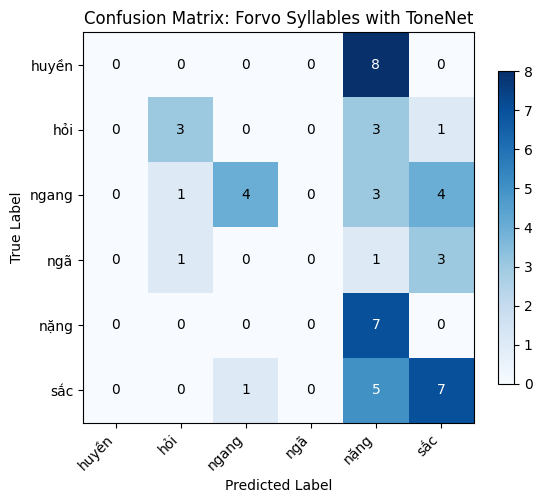

In [ ]:
X_forvo = np.load(f"{forvo_pkg}/X.npy")    # (N_forvo, 1, 64, 225)
y_forvo = np.load(f"{forvo_pkg}/y.npy")    # (N_forvo,)

# 4) Wrap each split in TensorDataset
ds_forvo = TensorDataset(
    torch.tensor(X_forvo, dtype=torch.float32),
    torch.tensor(y_forvo, dtype=torch.long)
)

test_loader  = DataLoader(ds_forvo, batch_size=16, shuffle=False, pin_memory=True)

forvo_preds, forvo_true = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        forvo_preds.extend(out.cpu().tolist())
        forvo_true.extend(yb.cpu().tolist())

# ── Step J) Print reports ─────────────────────────────────────────────────
with open(f"{forvo_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print("\n>>> Forvo — Metrics <<<")
print(classification_report(forvo_true, forvo_preds, target_names=label_names))
print(confusion_matrix(forvo_true, forvo_preds))
plot_confusion_matrix(confusion_matrix(forvo_true, forvo_preds),  label_names, "Confusion Matrix: Forvo Syllables with ToneNet")

In [ ]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  Fine‐tune ONNX→PyTorch ToneNet for 6 Vietnamese tones (batchable)  ║
# ╚═════════════════════════════════════════════════════════════════════╝

# 1) Install/Import dependencies
#!pip install onnx onnx2pytorch opencv-python

import onnx
from onnx2pytorch import ConvertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# 2) Load the ONNX graph and convert with experimental=True so batch_size>1 works
onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)
base_tonenet = ConvertModel(onnx_model, experimental=True)
base_tonenet.eval()

# 3) Locate and replace the final Linear (out_features=4 → out_features=6)
def replace_last_linear(module: nn.Module) -> nn.Linear:
    """
    Recursively find the first nn.Linear child with out_features==4,
    replace it with a new Linear(in_features, 6), and return the new module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and child.out_features == 4:
            in_feats = child.in_features
            new_head = nn.Linear(in_feats, 6)
            setattr(module, name, new_head)
            return new_head
        else:
            result = replace_last_linear(child)
            if isinstance(result, nn.Linear):
                return result
    return None

new_head = replace_last_linear(base_tonenet)
assert new_head is not None, "⚠️ Could not find and replace the 4-way Linear head."

# 4) Verify that the new head produces (1,6) from NHWC dummy
x_dummy = torch.randn(1, 225, 225, 3)  # NHWC: (batch, H=64, W=225, C=3)
with torch.no_grad():
    y_new = base_tonenet(x_dummy)
print("After swap, output shape (should be [1,6]):", y_new.shape)

# 5) Freeze all pretrained layers, then unfreeze only the new head
for param in base_tonenet.parameters():
    param.requires_grad = False

# Unfreeze the new head’s params
for param in new_head.parameters():
    param.requires_grad = True

# Confirm trainable params
print("\nTrainable parameters (only the new head):")
for name, param in base_tonenet.named_parameters():
    if param.requires_grad:
        print(f"  {name} {tuple(param.shape)}")

# 6) Build a new Dataset that uses raw dB (no min/max scaling)
class ToneNetRawDbDataset(Dataset):
    def __init__(self, X_npy_path, y_npy_path):
        self.X = np.load(X_npy_path)   # (N,1,64,225) in dB already
        self.y = np.load(y_npy_path)   # (N,)
        self.N = self.y.shape[0]
        self.target_size = (225, 225)
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        # 1) single-channel (64×225) in dB
        spec_db = self.X[idx, 0, :, :]
        # 2) clip to [−80, 0] (optional but matches ToneNet paper)
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) resize to (225,225)
        spec_resized = cv2.resize(spec_db, self.target_size, interpolation=cv2.INTER_LINEAR)
        # 4) replicate to 3 channels → NHWC
        img_nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        x = torch.from_numpy(img_nhwc.astype(np.float32))  # dtype=float32
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y
# 7) Instantiate dataset & split
pkg = drill_pkg

dataset = ToneNetRawDbDataset(
    f"{pkg}/drill_X.npy",
    f"{pkg}/drill_y.npy"
)
N = len(dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, pin_memory=True)
criterion = nn.CrossEntropyLoss()  # start without weighting
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, base_tonenet.parameters()),
    lr=1e-5
)
# 8) Fine-tune only the new head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_tonenet.to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    # Train
    model.train()
    total, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)          # NHWC input
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
    train_acc = correct / total

    # Validate
    model.eval()
    v_corr, v_tot = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            v_corr += (preds == yb).sum().item()
            v_tot  += yb.size(0)
    val_acc = v_corr / v_tot

    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

# 9) Test evaluation
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out= model(xb).cpu().argmax(dim=1)
        all_preds.extend(out.tolist())
        all_true.extend(yb.tolist())

with open(f"{pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print(classification_report(all_true, all_preds, target_names=label_names))
print(confusion_matrix(all_true, all_preds))

# 10) Save fine-tuned Vietnamese model
# save_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/ToneNet_VN_finetuned_lastLayer.pth"
# torch.save(model.state_dict(), save_path)
# print("✅ Saved fine-tuned model to", save_path)

## [ToneNet] Training Both Together and Evaluating Separately:

In [ ]:
# ── Step A) Imports ─────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset, random_split
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import json

# ── Step B) (Re)Build the ToneNet‐based model with a 6‐way head ───────────────
# We assume you have already converted ToneNet.hdf5→tonenet.onnx→ConvertModel,
# and replaced the final head with a 6‐way Linear. To keep things concise,
# we’ll re-load the ONNX→PyTorch module and swap the head here again.

from onnx2pytorch import ConvertModel
import onnx

onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)
model = ConvertModel(onnx_model, experimental=True)  # NHWC, batchable
model.eval()

# Recursively find the old 4-way Linear and replace it with 6-way:
def replace_last_linear(module: nn.Module) -> nn.Linear:
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and child.out_features == 4:
            new_head = nn.Linear(child.in_features, 6)
            setattr(module, name, new_head)
            return new_head
        else:
            result = replace_last_linear(child)
            if isinstance(result, nn.Linear):
                return result
    return None

new_head = replace_last_linear(model)
assert new_head is not None, "Could not find a 4→6 Linear to replace"

# ── Step C) Freeze all layers except the last two dense blocks + new head ──────
# (We know from the ONNX→PyTorch printout that the two 1024×1024 layers are
#  named “MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0”
#  and “MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0”, and
#  the final head is “dense_3/BiasAdd:0”.)

for name, param in model.named_parameters():
    if ("dense_1" in name or "dense_2" in name or "dense_3" in name
        or "batch_normalization_5" in name
        or "activation_5" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

print("Trainable parameters (should include the two 1024×1024 layers + head):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("  ", name, tuple(param.shape))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ── Step D) Helper to convert a batch of (1,64,225) → (225,225,3) NHWC ──────────
def batch_to_nhwc_rgb(xb: torch.Tensor) -> torch.Tensor:
    """
    xb: FloatTensor of shape (B, 1, 64, 225), in log-dB
    Returns: FloatTensor of shape (B, 225, 225, 3), also in log-dB units.
    """
    B = xb.shape[0]
    out = torch.zeros((B, 225, 225, 3), dtype=torch.float32, device=xb.device)
    xb_np = xb.cpu().numpy()  # move to CPU to use cv2.resize
    for i in range(B):
        # 1) Take (1,64,225) → (64,225)
        spec_db = xb_np[i, 0, :, :]
        # 2) Clip to [–80, 0] dB (to match training preprocessing):
        spec_db = np.clip(spec_db, -80.0, 0.0)
        # 3) Resize to (225×225)
        spec_resized = cv2.resize(
            spec_db, (225, 225),
            interpolation=cv2.INTER_LINEAR
        )
        # 4) Replicate to 3 channels → (225,225,3)
        nhwc = np.stack([spec_resized, spec_resized, spec_resized], axis=-1)
        out[i] = torch.from_numpy(nhwc.astype(np.float32)).to(xb.device)
    return out

# ── Step E) Build train/val/test loaders (you already have these) ────────────
# (Provided in the prompt; included here for clarity)

from sklearn.model_selection import train_test_split

# 1) Load Synth-only vs. Real-only
X_synth = np.load(f"{synth_small_pkg_dir}/X.npy")    # (N_synth, 1, 64, 225)
y_synth = np.load(f"{synth_small_pkg_dir}/y.npy")    # (N_synth,)
X_real  = np.load(f"{drill_pkg}/drill_X.npy")        # (N_real,  1, 64, 225)
y_real  = np.load(f"{drill_pkg}/drill_y.npy")        # (N_real,)

# 2) Split synth → train/val/test (70/15/15) with stratification
synth_X_temp, synth_X_test, synth_y_temp, synth_y_test = train_test_split(
    X_synth, y_synth, test_size=0.15, random_state=42, stratify=y_synth
)
synth_X_train, synth_X_val, synth_y_train, synth_y_val = train_test_split(
    synth_X_temp, synth_y_temp, test_size=0.1765,  # 0.1765×0.85 ≈ 0.15
    random_state=42, stratify=synth_y_temp
)

# 3) Split real → train/val/test (70/15/15)
real_X_temp, real_X_test, real_y_temp, real_y_test = train_test_split(
    X_real, y_real, test_size=0.15, random_state=42, stratify=y_real
)
real_X_train, real_X_val, real_y_train, real_y_val = train_test_split(
    real_X_temp, real_y_temp, test_size=0.1765, random_state=42, stratify=real_y_temp
)

# 4) Wrap each split in TensorDataset
ds_synth_train = TensorDataset(
    torch.tensor(synth_X_train, dtype=torch.float32),
    torch.tensor(synth_y_train, dtype=torch.long)
)
ds_synth_val = TensorDataset(
    torch.tensor(synth_X_val, dtype=torch.float32),
    torch.tensor(synth_y_val, dtype=torch.long)
)
ds_synth_test = TensorDataset(
    torch.tensor(synth_X_test, dtype=torch.float32),
    torch.tensor(synth_y_test, dtype=torch.long)
)

ds_real_train = TensorDataset(
    torch.tensor(real_X_train, dtype=torch.float32),
    torch.tensor(real_y_train, dtype=torch.long)
)
ds_real_val = TensorDataset(
    torch.tensor(real_X_val, dtype=torch.float32),
    torch.tensor(real_y_val, dtype=torch.long)
)
ds_real_test = TensorDataset(
    torch.tensor(real_X_test, dtype=torch.float32),
    torch.tensor(real_y_test, dtype=torch.long)
)

# 5) Combine & create DataLoaders
train_ds = torch.utils.data.ConcatDataset([ds_synth_train, ds_real_train])
val_ds   = torch.utils.data.ConcatDataset([ds_synth_val,   ds_real_val  ])

train_loader       = DataLoader(train_ds, batch_size=32, shuffle=True,  pin_memory=True)
val_loader         = DataLoader(val_ds,   batch_size=64, shuffle=False, pin_memory=True)
loader_synth_test  = DataLoader(ds_synth_test, batch_size=64, shuffle=False, pin_memory=True)
loader_real_test   = DataLoader(ds_real_test,  batch_size=64, shuffle=False, pin_memory=True)

# ── Step F) Set up optimizer & loss ────────────────────────────────────────
# ── Define three parameter‐groups: conv5, dense1+2, and new_head ────────────
conv5_params        = []
dense1and2_params   = []
new_head_params     = []

for name, param in model.named_parameters():
    # 1) conv5 block: look for any layer in the 5th conv‐BN sequence
    #    In the ConvertModel naming, conv5 layers often contain "conv2d_5"
    #    or "batch_normalization_5". Adjust if your names differ.
    if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
        conv5_params.append(param)

    # 2) dense1 & dense2: look for MatMul/.../dense_1 or dense_2
    #    In ONNX→PyTorch they appear as "MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight", etc.
    elif ("dense_1" in name) or ("dense_2" in name):
        dense1and2_params.append(param)

    # 3) new head = dense_3 (the 4→6 Linear you swapped in)
    elif "dense_3" in name:
        new_head_params.append(param)

optimizer = torch.optim.Adam([
    {"params": conv5_params,    "lr": 5e-6},
    {"params": dense1and2_params,"lr": 1e-5},
    {"params": new_head_params,  "lr": 1e-3}
])
criterion = nn.CrossEntropyLoss()

# ── Step G) Training loop (mixed train/val) ────────────────────────────────
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_corr, running_tot = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        # 1) Convert (B,1,64,225) → (B,225,225,3) NHWC
        xb_nhwc = batch_to_nhwc_rgb(xb)
        optimizer.zero_grad()
        logits = model(xb_nhwc)             # shape=(B, 6)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        running_corr += (preds == yb).sum().item()
        running_tot  += yb.size(0)

    train_acc = running_corr / running_tot

    #  Validate on the mixed val set
    model.eval()
    v_corr, v_tot = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_nhwc = batch_to_nhwc_rgb(xb)
            preds = model(xb_nhwc).argmax(dim=1)
            v_corr += (preds == yb).sum().item()
            v_tot  += yb.size(0)
    val_acc = v_corr / v_tot

    print(f"Epoch {epoch+1:2d}/{num_epochs:2d}  "
          f"train_acc={train_acc:.3f}  val_acc={val_acc:.3f}")

# ── Step H) Evaluate on separate synth‐only test set ───────────────────────
all_synth_preds, all_synth_true = [], []
model.eval()
with torch.no_grad():
    for xb, yb in loader_synth_test:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        all_synth_preds.extend(out.cpu().tolist())
        all_synth_true.extend(yb.cpu().tolist())

# ── Step I) Evaluate on separate real‐only test set ────────────────────────
all_real_preds, all_real_true = [], []
with torch.no_grad():
    for xb, yb in loader_real_test:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        all_real_preds.extend(out.cpu().tolist())
        all_real_true.extend(yb.cpu().tolist())

# ── Step J) Print reports ─────────────────────────────────────────────────
with open(f"{combined_pkg_small}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print("\n>>> Synthetic‐only Test — Metrics <<<")
print(classification_report(all_synth_true, all_synth_preds, target_names=label_names))
print(confusion_matrix(all_synth_true, all_synth_preds))

print("\n>>> Real‐only Test — Metrics <<<")
print(classification_report(all_real_true, all_real_preds, target_names=label_names))
print(confusion_matrix(all_real_true, all_real_preds))


/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


Trainable parameters (should include the two 1024×1024 layers + head):
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.weight (512, 256, 3, 3)
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.bias (512,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight (1024, 2048)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.weight (1024, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.weight (6, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.bias (6,)
Epoch  1/25  train_acc=0.280  val_acc=0.388
Epoch  2/25  train_acc=0.500  val_acc=0.564
Epoch  3/25  train_acc=0.604  val_acc=0.644
Epoch  4/25  train_acc=0.647  val_acc=0.671
Epoch  5/25  train_acc=0.733  val_acc=0.750
Epoch  6/25  train

/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))
/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


Trainable parameters (should include the two 1024×1024 layers + head):
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.weight (512, 256, 3, 3)
   Conv_StatefulPartitionedCall/sequential_1/batch_normalization_5/FusedBatchNormV3:0.bias (512,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.weight (1024, 2048)
   MatMul_StatefulPartitionedCall/sequential_1/dense_1/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.weight (1024, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_2/BiasAdd:0.bias (1024,)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.weight (6, 1024)
   MatMul_StatefulPartitionedCall/sequential_1/dense_3/BiasAdd:0.bias (6,)
Epoch  1/25  Train Loss: 1.7698, Train Acc: 0.240  |  Val Loss:   1.7326, Val Acc:   0.285
Epoch  2/25  Train Loss: 1.6951, Train Acc: 0.356  |  Val Loss:   1.6249, Val Acc:   0.503
Epoch  3/25  Train Loss: 1.5586, Train Acc: 0.553  |  Va

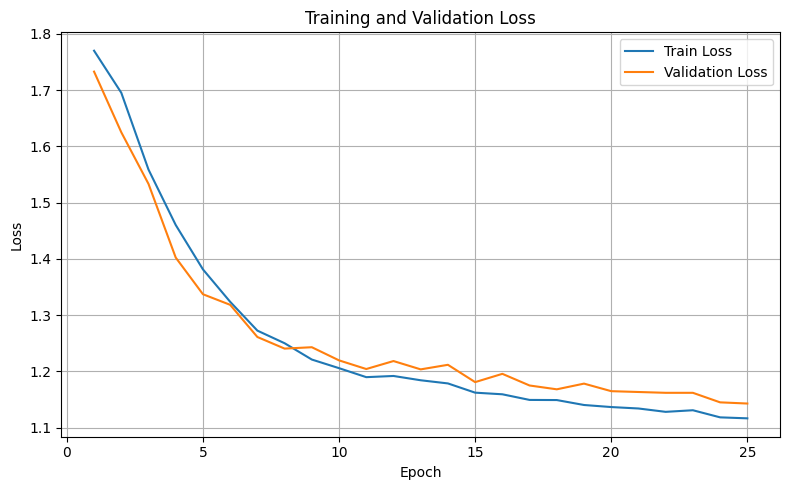

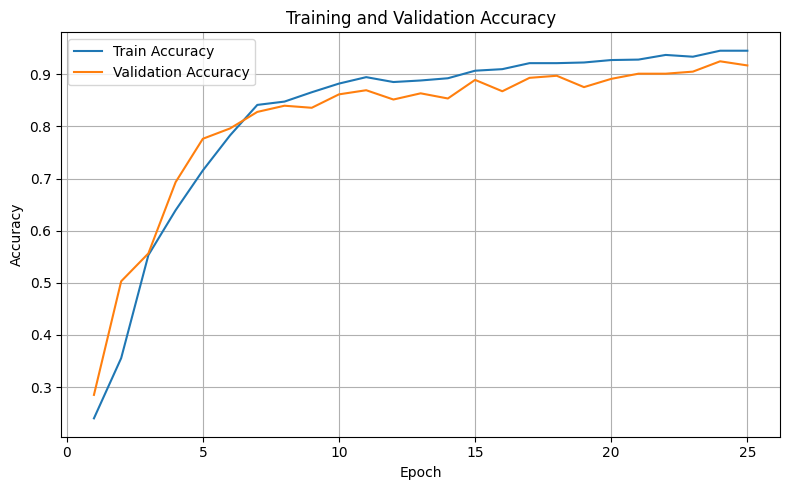


>>> Synthetic‐only Test — Metrics <<<
              precision    recall  f1-score   support

       huyền       0.92      1.00      0.96        45
         hỏi       0.86      0.98      0.92        45
       ngang       1.00      0.84      0.92        45
         ngã       0.79      0.93      0.86        45
        nặng       0.91      0.87      0.89        45
         sắc       0.89      0.71      0.79        45

    accuracy                           0.89       270
   macro avg       0.89      0.89      0.89       270
weighted avg       0.89      0.89      0.89       270

[[45  0  0  0  0  0]
 [ 1 44  0  0  0  0]
 [ 2  3 38  0  2  0]
 [ 0  1  0 42  0  2]
 [ 1  3  0  0 39  2]
 [ 0  0  0 11  2 32]]

>>> Real‐only Test — Metrics <<<
              precision    recall  f1-score   support

       huyền       0.94      0.94      0.94        34
         hỏi       0.93      0.96      0.95        28
       ngang       1.00      0.95      0.97        37
         ngã       0.95      0.88      0

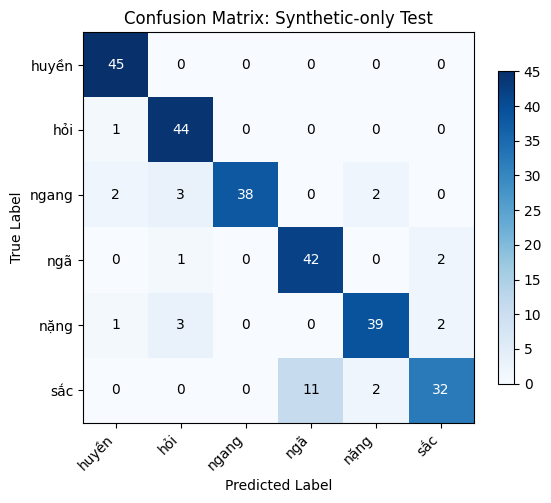

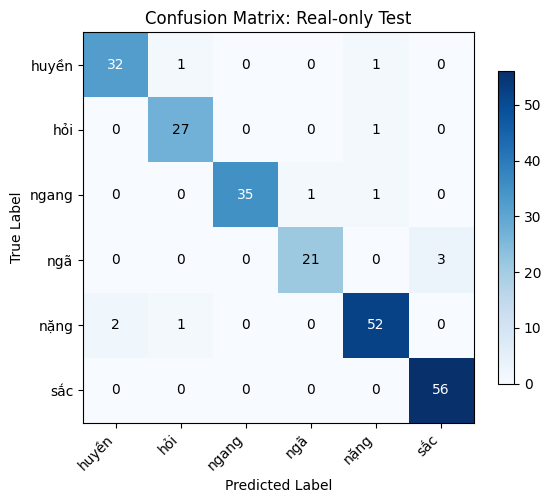

In [ ]:
# ── Step A) Imports ─────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset, random_split
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import json
import matplotlib.pyplot as plt

# ── Step B) (Re)Build the ToneNet‐based model with a 6‐way head ───────────────
from onnx2pytorch import ConvertModel
import onnx

onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)
model = ConvertModel(onnx_model, experimental=True)  # NHWC, batchable
model.eval()

# Replace the final 4→6 Linear head:
def replace_last_linear(module: nn.Module) -> nn.Linear:
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and child.out_features == 4:
            new_head = nn.Linear(child.in_features, 6)
            setattr(module, name, new_head)
            return new_head
        else:
            result = replace_last_linear(child)
            if isinstance(result, nn.Linear):
                return result
    return None

new_head = replace_last_linear(model)
assert new_head is not None, "Could not find a 4→6 Linear to replace"

# ── Step C) Freeze all layers except the last two dense blocks + new head ──────
for name, param in model.named_parameters():
    # Only enable gradients for the two 1024×1024 dense blocks & the new head:
    if ("dense_1" in name or "dense_2" in name or "dense_3" in name
        or "batch_normalization_5" in name
        or "activation_5" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

print("Trainable parameters (should include the two 1024×1024 layers + head):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("  ", name, tuple(param.shape))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ── Step D) Helper to convert a batch of (1,64,225) → (225,225,3) NHWC ──────────
def batch_to_nhwc_rgb(xb: torch.Tensor) -> torch.Tensor:
    """
    xb: FloatTensor of shape (B, 1, 64, 225), in log-dB
    Returns: FloatTensor of shape (B, 225, 225, 3), also in log-dB units.
    """
    B = xb.shape[0]
    out = torch.zeros((B, 225, 225, 3), dtype=torch.float32, device=xb.device)
    xb_np = xb.cpu().numpy()  # for cv2.resize
    for i in range(B):
        spec_db = xb_np[i, 0, :, :]                 # (64,225)
        spec_db = np.clip(spec_db, -80.0, 0.0)       # clip to [–80,0]
        spec_resized = cv2.resize(
            spec_db, (225, 225),
            interpolation=cv2.INTER_LINEAR
        )
        nhwc = np.stack([spec_resized]*3, axis=-1)   # (225,225,3)
        out[i] = torch.from_numpy(nhwc.astype(np.float32)).to(xb.device)
    return out

# ── Step E) Build train/val/test loaders ────────────────────────────────────
from sklearn.model_selection import train_test_split

X_synth = np.load(f"{synth_small_pkg_dir}/X.npy")    # (N_synth, 1, 64, 225)
y_synth = np.load(f"{synth_small_pkg_dir}/y.npy")    # (N_synth,)
X_real  = np.load(f"{drill_pkg}/drill_X.npy")        # (N_real,  1, 64, 225)
y_real  = np.load(f"{drill_pkg}/drill_y.npy")        # (N_real,)

# 1) Split synth → train/val/test (70/15/15) with stratification
synth_X_temp, synth_X_test, synth_y_temp, synth_y_test = train_test_split(
    X_synth, y_synth,
    test_size=0.15,
    random_state=42,
    stratify=y_synth
)
synth_X_train, synth_X_val, synth_y_train, synth_y_val = train_test_split(
    synth_X_temp, synth_y_temp,
    test_size=0.1765,  # 0.1765 × 0.85 ≈ 0.15
    random_state=42,
    stratify=synth_y_temp
)

# 2) Split real → train/val/test (70/15/15)
real_X_temp, real_X_test, real_y_temp, real_y_test = train_test_split(
    X_real, y_real,
    test_size=0.15,
    random_state=42,
    stratify=y_real
)
real_X_train, real_X_val, real_y_train, real_y_val = train_test_split(
    real_X_temp, real_y_temp,
    test_size=0.1765,
    random_state=42,
    stratify=real_y_temp
)

# 3) Wrap each split in TensorDataset
ds_synth_train = TensorDataset(
    torch.tensor(synth_X_train, dtype=torch.float32),
    torch.tensor(synth_y_train, dtype=torch.long)
)
ds_synth_val = TensorDataset(
    torch.tensor(synth_X_val, dtype=torch.float32),
    torch.tensor(synth_y_val, dtype=torch.long)
)
ds_synth_test = TensorDataset(
    torch.tensor(synth_X_test, dtype=torch.float32),
    torch.tensor(synth_y_test, dtype=torch.long)
)

ds_real_train = TensorDataset(
    torch.tensor(real_X_train, dtype=torch.float32),
    torch.tensor(real_y_train, dtype=torch.long)
)
ds_real_val = TensorDataset(
    torch.tensor(real_X_val, dtype=torch.float32),
    torch.tensor(real_y_val, dtype=torch.long)
)
ds_real_test = TensorDataset(
    torch.tensor(real_X_test, dtype=torch.float32),
    torch.tensor(real_y_test, dtype=torch.long)
)

# 4) Combine & create DataLoaders
train_ds = ConcatDataset([ds_synth_train, ds_real_train])
val_ds   = ConcatDataset([ds_synth_val,   ds_real_val  ])

train_loader       = DataLoader(train_ds, batch_size=32, shuffle=True,  pin_memory=True)
val_loader         = DataLoader(val_ds,   batch_size=64, shuffle=False, pin_memory=True)
loader_synth_test  = DataLoader(ds_synth_test, batch_size=64, shuffle=False, pin_memory=True)
loader_real_test   = DataLoader(ds_real_test,  batch_size=64, shuffle=False, pin_memory=True)

# ── Step F) Set up optimizer & loss ────────────────────────────────────────
conv5_params        = []
dense1and2_params   = []
new_head_params     = []

for name, param in model.named_parameters():
    if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
        conv5_params.append(param)
    elif ("dense_1" in name) or ("dense_2" in name):
        dense1and2_params.append(param)
    elif "dense_3" in name:
        new_head_params.append(param)

optimizer = torch.optim.Adam([
    {"params": conv5_params,     "lr": 5e-6},
    {"params": dense1and2_params,"lr": 1e-5},
    {"params": new_head_params,  "lr": 1e-3}
])
criterion = nn.CrossEntropyLoss()

# ── Step G) Training loop (with metric tracking) ───────────────────────────
num_epochs = 25

# Initialize lists to hold per-epoch metrics:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corr = 0
    running_tot  = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)     # (B,225,225,3)

        optimizer.zero_grad()
        logits = model(xb_nhwc)             # (B,6)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_corr += (preds == yb).sum().item()
        running_tot  += yb.size(0)

    epoch_train_loss = running_loss / running_tot
    epoch_train_acc  = running_corr / running_tot
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # ── Validation Phase ──
    model.eval()
    v_running_loss = 0.0
    v_running_corr = 0
    v_running_tot  = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_nhwc = batch_to_nhwc_rgb(xb)
            logits = model(xb_nhwc)
            loss   = criterion(logits, yb)

            v_running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            v_running_corr += (preds == yb).sum().item()
            v_running_tot  += yb.size(0)

    epoch_val_loss = v_running_loss / v_running_tot
    epoch_val_acc  = v_running_corr / v_running_tot
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1:2d}/{num_epochs:2d}  "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f}  |  "
          f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.3f}")

print("✅ Finished training. Collected metrics for each epoch.")

# ── Step H) Plot Loss & Accuracy Curves ─────────────────────────────────────
epochs = range(1, num_epochs + 1)

# 1) Loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ── Step I) Evaluate on separate synth‐only test set ────────────────────────
model.eval()
all_synth_preds = []
all_synth_true  = []
with torch.no_grad():
    for xb, yb in loader_synth_test:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        all_synth_preds.extend(out.cpu().tolist())
        all_synth_true.extend(yb.cpu().tolist())

# ── Step J) Evaluate on separate real‐only test set ────────────────────────
all_real_preds = []
all_real_true  = []
with torch.no_grad():
    for xb, yb in loader_real_test:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        all_real_preds.extend(out.cpu().tolist())
        all_real_true.extend(yb.cpu().tolist())

# ── Step K) Print reports & compute confusion matrices ────────────────────
with open(f"{synth_small_pkg_dir}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print("\n>>> Synthetic‐only Test — Metrics <<<")
print(classification_report(all_synth_true, all_synth_preds, target_names=label_names))
cm_synth = confusion_matrix(all_synth_true, all_synth_preds)
print(cm_synth)

print("\n>>> Real‐only Test — Metrics <<<")
print(classification_report(all_real_true, all_real_preds, target_names=label_names))
cm_real = confusion_matrix(all_real_true, all_real_preds)
print(cm_real)

# ── Step L) Plot Confusion Matrices as Heatmaps ────────────────────────────

plot_confusion_matrix(cm_synth, label_names, "Confusion Matrix: Synthetic‐only Test")
plot_confusion_matrix(cm_real,  label_names, "Confusion Matrix: Real‐only Test")



>>> Forvo — Metrics <<<
              precision    recall  f1-score   support

       huyền       0.00      0.00      0.00         8
         hỏi       0.30      0.43      0.35         7
       ngang       1.00      0.08      0.15        12
         ngã       0.20      0.40      0.27         5
        nặng       0.24      0.57      0.33         7
         sắc       0.36      0.38      0.37        13

    accuracy                           0.29        52
   macro avg       0.35      0.31      0.25        52
weighted avg       0.41      0.29      0.25        52

[[0 2 0 0 6 0]
 [0 3 0 2 2 0]
 [0 1 1 0 2 8]
 [0 1 0 2 1 1]
 [0 2 0 1 4 0]
 [0 1 0 5 2 5]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


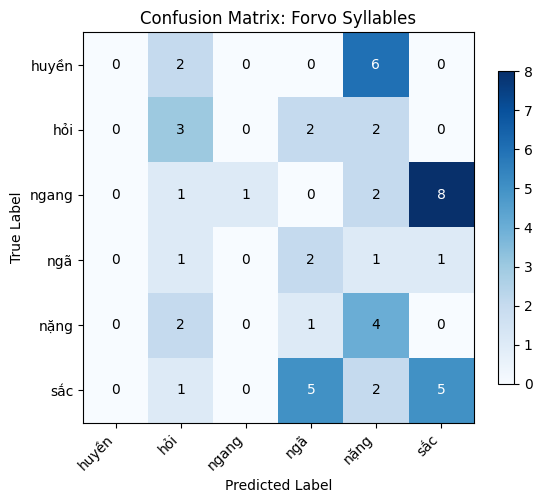

In [ ]:
X_forvo = np.load(f"{forvo_pkg}/X.npy")    # (N_synth, 1, 64, 225)
y_forvo = np.load(f"{forvo_pkg}/y.npy")    # (N_synth,)

# 4) Wrap each split in TensorDataset
ds_forvo = TensorDataset(
    torch.tensor(X_forvo, dtype=torch.float32),
    torch.tensor(y_forvo, dtype=torch.long)
)

test_loader       = DataLoader(ds_forvo, batch_size=64, shuffle=False, pin_memory=True)

# ── Step H) Evaluate on separate synth‐only test set ───────────────────────
all_synth_preds, all_synth_true = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        out     = model(xb_nhwc).argmax(dim=1)
        all_synth_preds.extend(out.cpu().tolist())
        all_synth_true.extend(yb.cpu().tolist())

# ── Step J) Print reports ─────────────────────────────────────────────────
with open(f"{forvo_pkg}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print("\n>>> Forvo — Metrics <<<")
print(classification_report(all_synth_true, all_synth_preds, target_names=label_names))
print(confusion_matrix(all_synth_true, all_synth_preds))

plot_confusion_matrix(confusion_matrix(all_synth_true, all_synth_preds),  label_names, "Confusion Matrix: Forvo Syllables")

## [ToneNet] Experiments

[Aug=False] mode=0, lr=1e-03, bs=16 → train_loss=1.4785, train_acc=0.620; val_loss=1.5142, val_acc=0.567
[Aug=True] mode=0, lr=1e-03, bs=16 → train_loss=1.5570, train_acc=0.533; val_loss=1.5964, val_acc=0.487
[Aug=False] mode=0, lr=1e-03, bs=32 → train_loss=1.4911, train_acc=0.642; val_loss=1.5091, val_acc=0.600
[Aug=True] mode=0, lr=1e-03, bs=32 → train_loss=1.5749, train_acc=0.538; val_loss=1.5958, val_acc=0.516
[Aug=False] mode=0, lr=1e-04, bs=16 → train_loss=1.7000, train_acc=0.438; val_loss=1.7080, val_acc=0.457
[Aug=True] mode=0, lr=1e-04, bs=16 → train_loss=1.7293, train_acc=0.366; val_loss=1.7339, val_acc=0.361
[Aug=False] mode=0, lr=1e-04, bs=32 → train_loss=1.7275, train_acc=0.317; val_loss=1.7368, val_acc=0.301
[Aug=True] mode=0, lr=1e-04, bs=32 → train_loss=1.7424, train_acc=0.323; val_loss=1.7494, val_acc=0.257
[Aug=False] mode=0, lr=1e-05, bs=16 → train_loss=1.7716, train_acc=0.255; val_loss=1.7778, val_acc=0.266
[Aug=True] mode=0, lr=1e-05, bs=16 → train_loss=1.7752, tra

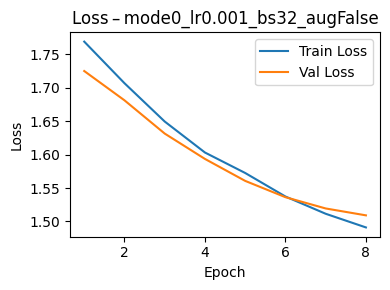

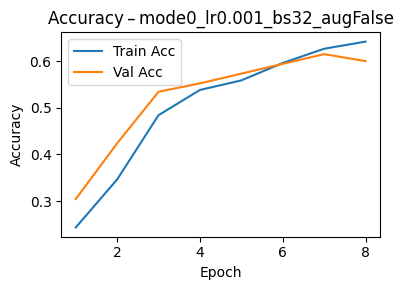

In [ ]:
import onnx
from onnx2pytorch import ConvertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import numpy as np
import cv2
import json
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# ── A) Helper: load & swap head ────────────────────────────────────────────
onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)

def make_tonenet():
    base = ConvertModel(onnx_model, experimental=True)
    base.eval()
    # Replace final 4→6 head
    def replace_last_linear(m):
        for name, child in m.named_children():
            if isinstance(child, nn.Linear) and child.out_features == 4:
                new_head = nn.Linear(child.in_features, 6)
                setattr(m, name, new_head)
                return True
            else:
                if replace_last_linear(child):
                    return True
        return False

    assert replace_last_linear(base), "Could not find 4→6 Linear"
    return base

# ── B) SpecAugment function ─────────────────────────────────────────────────
def spec_augment(spec_db: np.ndarray,
                 time_mask_pct: float = 0.10,
                 freq_mask_pct: float = 0.10) -> np.ndarray:
    """
    spec_db: (H=64, W) in dB
    time_mask_pct: fraction of time‐columns to zero out
    freq_mask_pct: fraction of frequency‐rows to zero out
    """
    H, W = spec_db.shape
    # frequency mask
    n_freq = int(H * freq_mask_pct)
    if n_freq > 0:
        f0 = np.random.randint(0, H - n_freq + 1)
        spec_db[f0 : f0 + n_freq, :] = -80.0

    # time mask
    n_time = int(W * time_mask_pct)
    if n_time > 0:
        t0 = np.random.randint(0, W - n_time + 1)
        spec_db[:, t0 : t0 + n_time] = -80.0

    return spec_db

# ── C) Dataset class with optional augmentation ────────────────────────────
class ToneNetRawDbDataset(Dataset):
    def __init__(self, X_npy, y_npy, augment=False):
        self.X = np.load(X_npy)   # (N,1,64,225), already in dB
        self.y = np.load(y_npy)   # (N,)
        self.N = len(self.y)
        self.target_size = (225,225)
        self.augment = augment

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        spec_db = self.X[idx, 0, :, :]            # shape = (64,225)
        spec_db = np.clip(spec_db, -80.0, 0.0)     # clip to [-80,0]

        # If augmentation is enabled, apply SpecAugment with 50% probability
        if self.augment and (np.random.rand() < 0.5):
            spec_db = spec_augment(spec_db, time_mask_pct=0.10, freq_mask_pct=0.10)

        # Resize to (225,225)
        spec_resized = cv2.resize(
            spec_db, self.target_size, interpolation=cv2.INTER_LINEAR
        )  # (225,225)

        # Replicate to 3 channels → NHWC
        img_nhwc = np.stack([spec_resized]*3, axis=-1)  # (225,225,3)

        x = torch.from_numpy(img_nhwc.astype(np.float32))  # dtype=float32
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

# ── D) batch_to_nhwc_rgb helper (just in case) ─────────────────────────────
def batch_to_nhwc_rgb(xb: torch.Tensor) -> torch.Tensor:
    """
    xb: FloatTensor of shape (B, 1, 64, 225), in log-dB
    Returns: FloatTensor of shape (B, 225, 225, 3), also in log-dB units.
    """
    B = xb.shape[0]
    out = torch.zeros((B, 225, 225, 3), dtype=torch.float32, device=xb.device)
    xb_np = xb.cpu().numpy()  # move to CPU to use cv2.resize
    for i in range(B):
        spec_db = xb_np[i, 0, :, :]            # (64,225)
        spec_db = np.clip(spec_db, -80.0, 0.0)  # ensure clipping
        spec_resized = cv2.resize(
            spec_db, (225, 225), interpolation=cv2.INTER_LINEAR
        )
        nhwc = np.stack([spec_resized]*3, axis=-1)  # (225,225,3)
        out[i] = torch.from_numpy(nhwc.astype(np.float32)).to(xb.device)
    return out

# ── E) Prepare one fixed train/val/test split ────────────────────────────────
pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_package_small"
# We only need indices; we'll attach augmentation later.
full_dataset = ToneNetRawDbDataset(f"{pkg}/X_full.npy", f"{pkg}/y_full.npy", augment=False)
N = len(full_dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val

all_indices = list(range(N))
train_indices, val_indices, test_indices = random_split(
    all_indices, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# ── F) Function to freeze/unfreeze layers by “mode” ─────────────────────────
def set_freeze(model, mode):
    """
    mode=0: freeze all except final head (dense_3)
    mode=1: unfreeze head + dense_1 + dense_2
    mode=2: unfreeze head + dense_1 + dense_2 + conv5 block
    mode=3: unfreeze head + all dense + all conv (full fine‐tune)
    """
    for param in model.parameters():
        param.requires_grad = False

    if mode >= 1:
        for name, param in model.named_parameters():
            if ("dense_1" in name) or ("dense_2" in name) or ("dense_3" in name):
                param.requires_grad = True

    if mode >= 2:
        for name, param in model.named_parameters():
            if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
                param.requires_grad = True

    if mode >= 3:
        for name, param in model.named_parameters():
            if "conv2d_" in name or "batch_normalization_" in name or "activation_" in name:
                param.requires_grad = True

    if mode == 0:
        for name, param in model.named_parameters():
            if "dense_3" in name:
                param.requires_grad = True

# ── G) Prepare Forvo test DataLoader ───────────────────────────────────────
forvo_pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/forvo_syllables"
X_forvo = np.load(f"{forvo_pkg}/X.npy")    # (N_forvo, 1, 64, 225)
y_forvo = np.load(f"{forvo_pkg}/y.npy")    # (N_forvo,)
ds_forvo = TensorDataset(
    torch.tensor(X_forvo, dtype=torch.float32),
    torch.tensor(y_forvo, dtype=torch.long)
)
forvo_loader = DataLoader(ds_forvo, batch_size=16, shuffle=False, pin_memory=True)

# ── H) train_and_eval with per‐epoch tracking + Forvo eval ──────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_eval(freeze_mode, lr, batch_size, augment=False, epochs=15):
    """
    Returns:
      train_losses:  list of length=epochs
      train_accs:    list of length=epochs
      val_losses:    list of length=epochs
      val_accs:      list of length=epochs
      test_acc:      final accuracy on held‐out test split (synthetic+drill)
      forvo_acc:     final accuracy on the Forvo set
    """
    # 1) Build fresh model & swap head
    model = make_tonenet().to(device)
    set_freeze(model, freeze_mode)

    # 2) Collect parameter groups for discriminative LR
    conv5_params = []
    dense1and2_params = []
    new_head_params   = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
            conv5_params.append(param)
        elif ("dense_1" in name) or ("dense_2" in name):
            dense1and2_params.append(param)
        elif "dense_3" in name:
            new_head_params.append(param)

    param_groups = []
    if freeze_mode >= 2 and conv5_params:
        param_groups.append({"params": conv5_params,       "lr": lr * 0.1})
    if freeze_mode >= 1 and dense1and2_params:
        param_groups.append({"params": dense1and2_params,  "lr": lr * 0.5})
    if new_head_params:
        param_groups.append({"params": new_head_params,    "lr": lr})

    optimizer = torch.optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()

    # 3) Build DataLoaders with/without augmentation
    full_aug_dataset = ToneNetRawDbDataset(f"{pkg}/X_full.npy", f"{pkg}/y_full.npy", augment=augment)
    train_ds = torch.utils.data.Subset(full_aug_dataset, train_indices)
    val_ds   = torch.utils.data.Subset(full_aug_dataset, val_indices)
    test_ds  = torch.utils.data.Subset(full_aug_dataset, test_indices)

    train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  pin_memory=True)
    val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, pin_memory=True)

    # 4) Placeholders for per-epoch metrics
    train_losses = []
    train_accs   = []
    val_losses   = []
    val_accs     = []

    # 5) Training loop
    for epoch in range(epochs):
        model.train()
        tot, corr, loss_sum = 0, 0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)            # NHWC input
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                preds = logits.argmax(dim=1)
                corr += (preds == yb).sum().item()
                tot  += yb.size(0)
                loss_sum += loss.item() * yb.size(0)

        train_acc  = corr / tot
        train_loss = loss_sum / tot
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 6) Validation
        model.eval()
        v_corr, v_tot, v_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss   = criterion(logits, yb)
                preds  = logits.argmax(dim=1)
                v_corr += (preds == yb).sum().item()
                v_tot  += yb.size(0)
                v_loss_sum += loss.item() * yb.size(0)

        val_acc  = v_corr / v_tot
        val_loss = v_loss_sum / v_tot
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        # Print last epoch only (to reduce clutter)
        if epoch == epochs - 1:
            print(f"[Aug={augment}] mode={freeze_mode}, lr={lr:.0e}, bs={batch_size} → "
                  f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}; "
                  f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")

    # 7) Test on held‐out (synthetic+drill) split
    model.eval()
    t_corr, t_tot = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            t_corr += (preds == yb).sum().item()
            t_tot  += yb.size(0)
    test_acc = t_corr / t_tot

    # 8) Finally, evaluate on the Forvo set
    forvo_preds, forvo_true = [], []
    with torch.no_grad():
        for xb, yb in forvo_loader:
            xb, yb = xb.to(device), yb.to(device)
            # If forvo_loader yields (1,64,225) → convert to NHWC:
            # for use of ToneNetRawDbDataset we assume it's already NHWC. If it's not, do:
            xb_nhwc = batch_to_nhwc_rgb(xb)
            preds = model(xb_nhwc).argmax(dim=1)
            forvo_preds.extend(preds.cpu().tolist())
            forvo_true.extend(yb.cpu().tolist())
    forvo_acc = sum(int(p==t) for p,t in zip(forvo_preds, forvo_true)) / len(forvo_true)

    return train_losses, train_accs, val_losses, val_accs, test_acc, forvo_acc

# ── I) Run a grid over freeze_mode, lr, batch_size, augment True/False ─────
results = []
all_histories = {}  # store per‐epoch curves

for freeze_mode in [0, 1, 2, 3]:
    for lr in [1e-3, 1e-4, 1e-5]:
        for bs in [16, 32]:
            for augment in [False, True]:
                key = f"mode{freeze_mode}_lr{lr}_bs{bs}_aug{augment}"
                train_losses, train_accs, val_losses, val_accs, te_acc, fv_acc = train_and_eval(
                    freeze_mode, lr, bs, augment=augment, epochs=8
                )
                results.append({
                    "config": key,
                    "freeze_mode": freeze_mode,
                    "lr": lr,
                    "batch_size": bs,
                    "augment": augment,
                    "test_acc": te_acc,
                    "forvo_acc": fv_acc
                })
                # Save the per-epoch curves:
                all_histories[key] = {
                    "train_losses": train_losses,
                    "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs
                }

# ── J) Summarize results in a DataFrame ────────────────────────────────────
df_res = pd.DataFrame(results)
print("Top 10 by val_acc (last epoch):")
# We didn’t store val_acc in results, but you can reconstruct it from all_histories.
# For simplicity, just sort by forvo_acc here:
print(df_res.sort_values("forvo_acc", ascending=False).head(10))

# ── K) Example plotting for one configuration ─────────────────────────────
# Suppose we want to plot the train/val curves for the best “forvo_acc” config:
best_cfg = df_res.sort_values("forvo_acc", ascending=False).iloc[0]["config"]
history = all_histories[best_cfg]

epochs = list(range(1, len(history["train_losses"]) + 1))

# Plot Loss
plt.figure(figsize=(4,3))
plt.plot(epochs, history["train_losses"], label="Train Loss")
plt.plot(epochs, history["val_losses"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss – {best_cfg}")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(4,3))
plt.plot(epochs, history["train_accs"], label="Train Acc")
plt.plot(epochs, history["val_accs"],   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Accuracy – {best_cfg}")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ── J) Summarize results in a DataFrame ────────────────────────────────────
df_res = pd.DataFrame(results)
print("Top 10 by val_acc (last epoch):")
# We didn’t store val_acc in results, but you can reconstruct it from all_histories.
# For simplicity, just sort by forvo_acc here:
print(df_res.sort_values("forvo_acc", ascending=False).head(10))

Top 10 by val_acc (last epoch):
                          config  freeze_mode      lr  batch_size  augment  \
2    mode0_lr0.001_bs32_augFalse            0  0.0010          32    False   
19   mode1_lr0.0001_bs32_augTrue            1  0.0001          32     True   
17   mode1_lr0.0001_bs16_augTrue            1  0.0001          16     True   
30  mode2_lr0.0001_bs32_augFalse            2  0.0001          32    False   
41   mode3_lr0.0001_bs16_augTrue            3  0.0001          16     True   
31   mode2_lr0.0001_bs32_augTrue            2  0.0001          32     True   
28  mode2_lr0.0001_bs16_augFalse            2  0.0001          16    False   
40  mode3_lr0.0001_bs16_augFalse            3  0.0001          16    False   
0    mode0_lr0.001_bs16_augFalse            0  0.0010          16    False   
18  mode1_lr0.0001_bs32_augFalse            1  0.0001          32    False   

    test_acc  forvo_acc  
2   0.617211   0.403846  
19  0.608309   0.384615  
17  0.652819   0.384615  
30  0

Saved grid‐search results to:
  /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/grid_results.csv
  /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/histories.pkl and histories.json

Also saved updated DataFrame (with val_acc, train_acc) to grid_results_with_val.csv


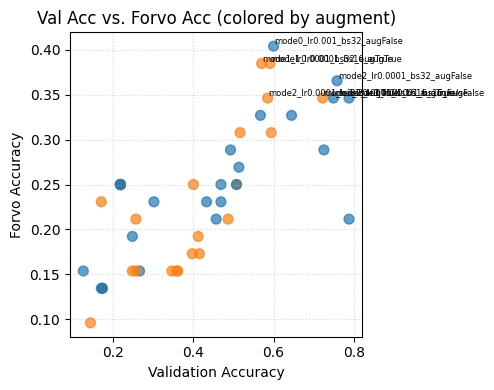

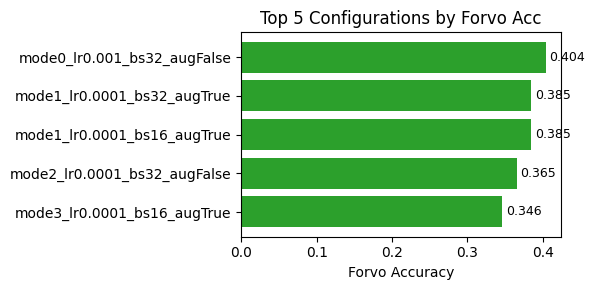

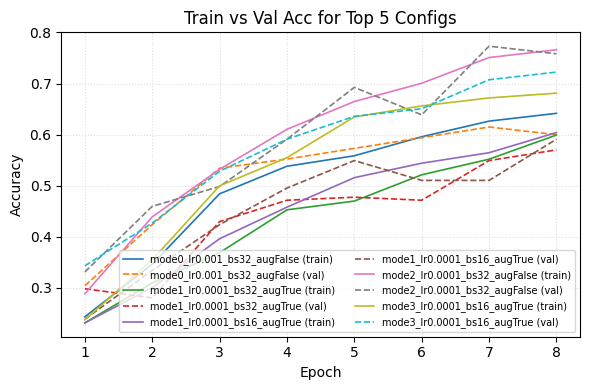

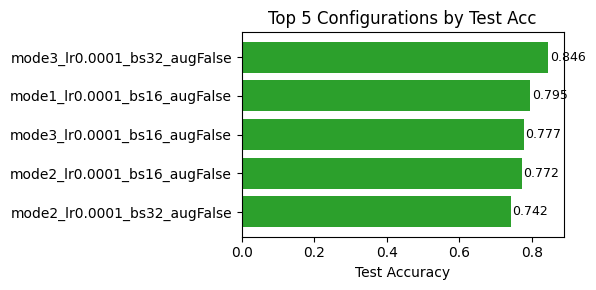

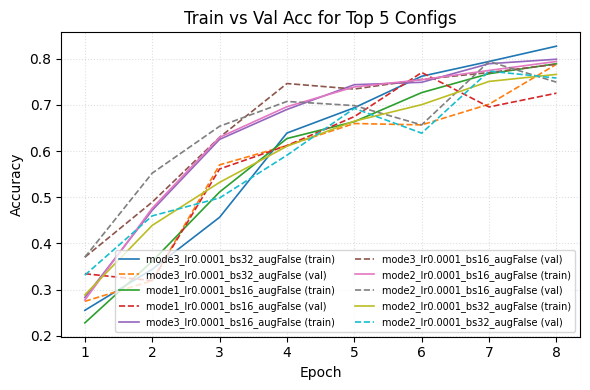

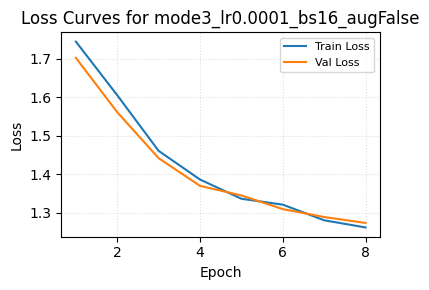


Summary of Top‐10 Configurations by Forvo Acc:

                      config  freeze_mode     lr  batch_size  augment  train_acc  val_acc  test_acc  forvo_acc
 mode0_lr0.001_bs32_augFalse            0 0.0010          32    False   0.641713 0.600000  0.617211   0.403846
 mode1_lr0.0001_bs32_augTrue            1 0.0001          32     True   0.599255 0.570149  0.608309   0.384615
 mode1_lr0.0001_bs16_augTrue            1 0.0001          16     True   0.604097 0.591045  0.652819   0.384615
mode2_lr0.0001_bs32_augFalse            2 0.0001          32    False   0.766108 0.758209  0.741840   0.365385
 mode3_lr0.0001_bs16_augTrue            3 0.0001          16     True   0.681192 0.722388  0.676558   0.346154
 mode2_lr0.0001_bs32_augTrue            2 0.0001          32     True   0.621601 0.585075  0.605341   0.346154
mode2_lr0.0001_bs16_augFalse            2 0.0001          16    False   0.794041 0.749254  0.771513   0.346154
mode3_lr0.0001_bs16_augFalse            3 0.0001          16   

In [ ]:
import os
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────── 1) Setup paths ──────────────────
save_dir = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results"
os.makedirs(save_dir, exist_ok=True)

# Assume df_res and all_histories already exist in this notebook:
#   - df_res: DataFrame with columns ["config","freeze_mode","lr","batch_size","augment","test_acc","forvo_acc"]
#   - all_histories: dict mapping each config → {"train_losses":[…], "train_accs":[…], "val_losses":[…], "val_accs":[…]}

# ─────────────── 2) Save df_res and all_histories ──────────────────
# 2a) Save the DataFrame to CSV
df_res.to_csv(os.path.join(save_dir, "grid_results.csv"), index=False)

# 2b) Save full histories as a pickle (preferred for preserving Python lists)
with open(os.path.join(save_dir, "histories.pkl"), "wb") as f:
    pickle.dump(all_histories, f)

# 2c) (Optional) Also save as JSON (so you can inspect with a text editor)
with open(os.path.join(save_dir, "histories.json"), "w") as f:
    # JSON requires Python lists, so this works directly since our histories are lists of floats
    json.dump(all_histories, f)

print(f"Saved grid‐search results to:\n  {save_dir}/grid_results.csv\n"
      f"  {save_dir}/histories.pkl and histories.json\n")

# ─────────────── 3) Augment df_res with final‐epoch val/train accuracy ─────
# We assume each history has length = num_epochs (e.g. 8).
# So the last element of val_accs, train_accs is “final validation accuracy” per run.
df_res["val_acc"]   = df_res["config"].apply(lambda cfg: all_histories[cfg]["val_accs"][-1])
df_res["train_acc"] = df_res["config"].apply(lambda cfg: all_histories[cfg]["train_accs"][-1])

# You can now reorder columns if you like:
df_res = df_res[[
    "config","freeze_mode","lr","batch_size","augment",
    "train_acc","val_acc","test_acc","forvo_acc"
]]

# Save the augmented DataFrame
df_res.to_csv(os.path.join(save_dir, "grid_results_with_val.csv"), index=False)
print("Also saved updated DataFrame (with val_acc, train_acc) to grid_results_with_val.csv")

# ─────────────── 4) Quick plots ─────────────────────────────────────────
# 4a) Scatter: val_acc vs forvo_acc, color by augment
plt.figure(figsize=(5,4))
colors = df_res["augment"].map({True: "C1", False: "C0"})
plt.scatter(df_res["val_acc"], df_res["forvo_acc"], c=colors, s=50, alpha=0.7)
for row in df_res.itertuples():
    # Optionally annotate a few points with their config name
    if row.forvo_acc >= df_res["forvo_acc"].quantile(0.90):
        plt.text(row.val_acc + 0.002, row.forvo_acc + 0.002, row.config, fontsize=6)
plt.xlabel("Validation Accuracy")
plt.ylabel("Forvo Accuracy")
plt.title("Val Acc vs. Forvo Acc (colored by augment)")
plt.grid(ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# 4b) Horizontal bar: Top‐5 configs by forvo_acc
top5 = df_res.sort_values("forvo_acc", ascending=False).head(5).copy()
plt.figure(figsize=(6,3))
plt.barh(top5["config"], top5["forvo_acc"], color="C2")
for i, (cfg, acc) in enumerate(zip(top5["config"], top5["forvo_acc"])):
    plt.text(acc + 0.005, i, f"{acc:.3f}", va="center", fontsize=9)
plt.xlabel("Forvo Accuracy")
plt.title("Top 5 Configurations by Forvo Acc")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()

# 4c) Overlay training & validation curves for those top‐5 configs
plt.figure(figsize=(6,4))
for cfg in top5["config"]:
    hist = all_histories[cfg]
    epochs = range(1, len(hist["train_accs"]) + 1)
    plt.plot(epochs, hist["train_accs"],    "-", label=f"{cfg} (train)",   linewidth=1.2)
    plt.plot(epochs, hist["val_accs"],      "--", label=f"{cfg} (val)",     linewidth=1.2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Acc for Top 5 Configs")
plt.legend(fontsize=7, ncol=2, loc="lower right")
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

# 4d) Horizontal bar: Top‐5 configs by test_acc
top5 = df_res.sort_values("test_acc", ascending=False).head(5).copy()
plt.figure(figsize=(6,3))
plt.barh(top5["config"], top5["test_acc"], color="C2")
for i, (cfg, acc) in enumerate(zip(top5["config"], top5["test_acc"])):
    plt.text(acc + 0.005, i, f"{acc:.3f}", va="center", fontsize=9)
plt.xlabel("Test Accuracy")
plt.title("Top 5 Configurations by Test Acc")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()


# 4e) Overlay training & validation curves for those top‐5 configs
plt.figure(figsize=(6,4))
for cfg in top5["config"]:
    hist = all_histories[cfg]
    epochs = range(1, len(hist["train_accs"]) + 1)
    plt.plot(epochs, hist["train_accs"],    "-", label=f"{cfg} (train)",   linewidth=1.2)
    plt.plot(epochs, hist["val_accs"],      "--", label=f"{cfg} (val)",     linewidth=1.2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Acc for Top 5 Configs")
plt.legend(fontsize=7, ncol=2, loc="lower right")
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

# 4f) Plot loss curves for the very best config by val_acc
best_by_val = df_res.sort_values("val_acc", ascending=False).iloc[0]["config"]
hist_best   = all_histories[best_by_val]
epochs = range(1, len(hist_best["train_losses"]) + 1)

plt.figure(figsize=(4,3))
plt.plot(epochs, hist_best["train_losses"], label="Train Loss")
plt.plot(epochs, hist_best["val_losses"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curves for {best_by_val}")
plt.legend(fontsize=8)
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

# 4g) (Optional) Show the DataFrame summary
print("\nSummary of Top‐10 Configurations by Forvo Acc:\n")
print(df_res.sort_values("forvo_acc", ascending=False).head(10).to_string(index=False))

# 4g) (Optional) Show the DataFrame summary
print("\nSummary of Top‐10 Configurations by Test Acc:\n")
print(df_res.sort_values("test_acc", ascending=False).head(10).to_string(index=False))

Retraining these configs for 25 epochs: ['mode0_lr0.001_bs32_augFalse', 'mode1_lr0.0001_bs32_augTrue', 'mode1_lr0.0001_bs16_augTrue', 'mode2_lr0.0001_bs32_augFalse', 'mode3_lr0.0001_bs16_augTrue', 'mode2_lr0.0001_bs32_augTrue', 'mode2_lr0.0001_bs16_augFalse', 'mode3_lr0.0001_bs16_augFalse', 'mode0_lr0.001_bs16_augFalse', 'mode1_lr0.0001_bs32_augFalse']

=== Running mode0_lr0.001_bs32_augFalse for 25 epochs ===


/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


→ Final Epoch: train_acc=0.665, val_acc=0.618
Saved 25‐epoch weights to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/mode0_lr0.001_bs32_augFalse_25epoch.pth


=== Running mode1_lr0.0001_bs32_augTrue for 25 epochs ===
→ Final Epoch: train_acc=0.742, val_acc=0.743
Saved 25‐epoch weights to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/mode1_lr0.0001_bs32_augTrue_25epoch.pth


=== Running mode1_lr0.0001_bs16_augTrue for 25 epochs ===
→ Final Epoch: train_acc=0.752, val_acc=0.746
Saved 25‐epoch weights to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/mode1_lr0.0001_bs16_augTrue_25epoch.pth


=== Running mode2_lr0.0001_bs32_augFalse for 25 epochs ===
→ Final Epoch: train_acc=0.835, val_acc=0.797
Saved 25‐epoch weights to /content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/mode2_lr0.0001_bs32_augFalse_25epoch.pth


=== Running mode3_lr0.0001_bs16_augTrue for 25 epochs ===
→ Final Epoch: tra

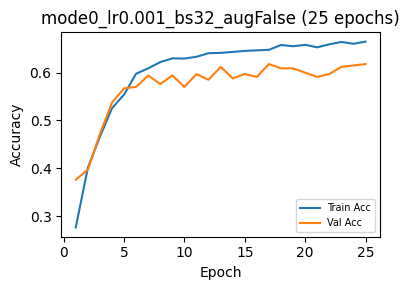

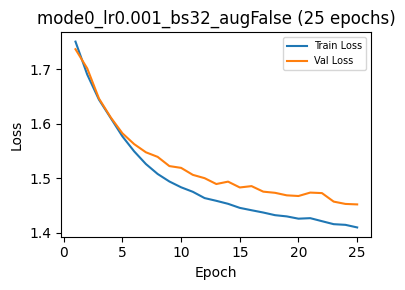

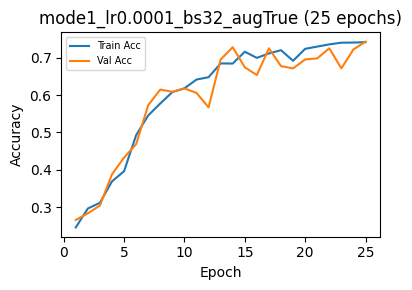

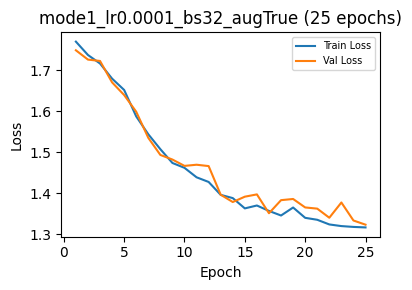

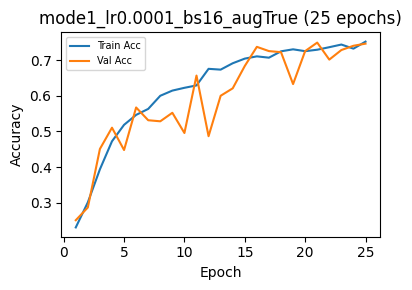

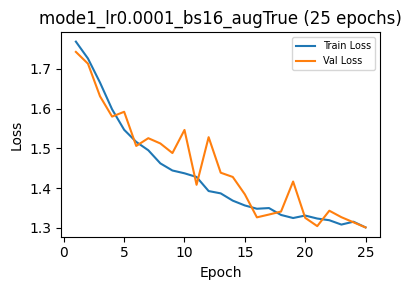

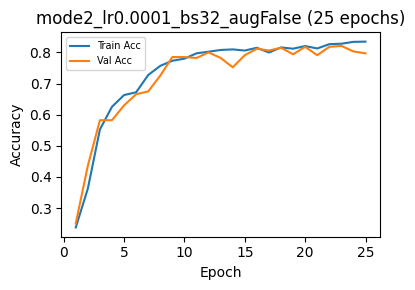

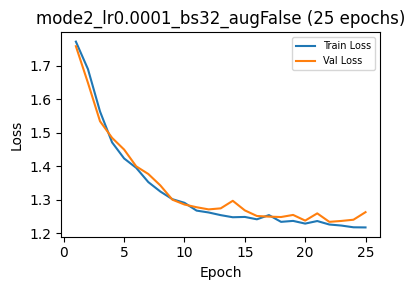

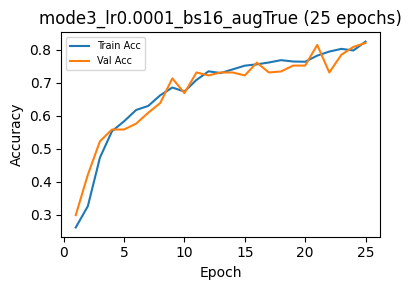

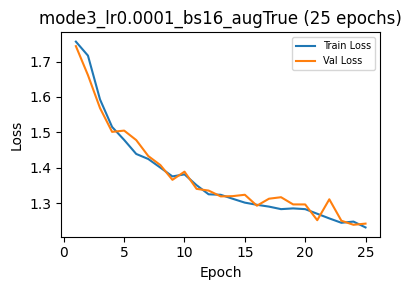

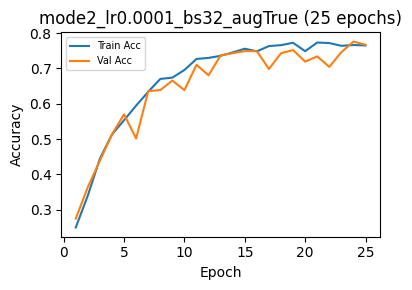

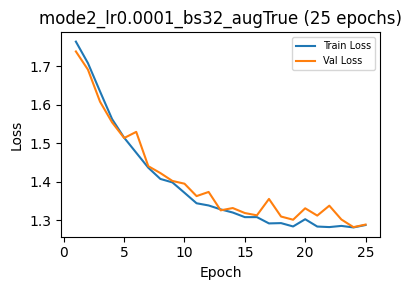

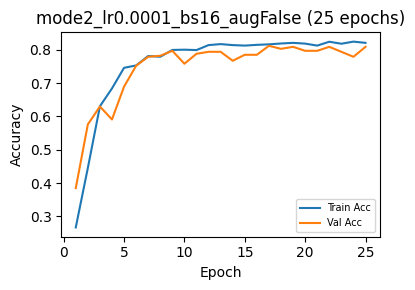

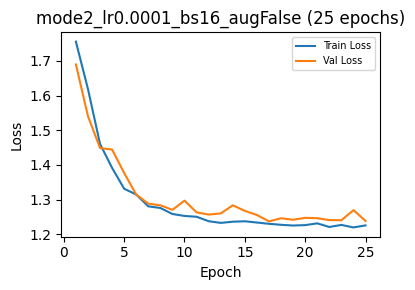

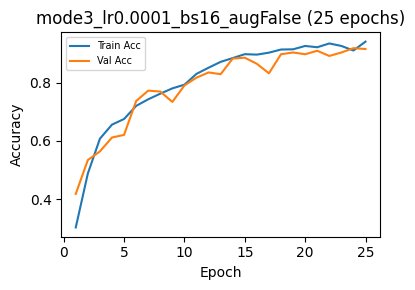

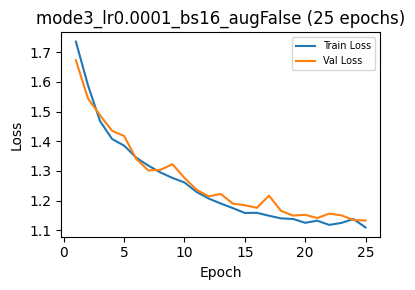

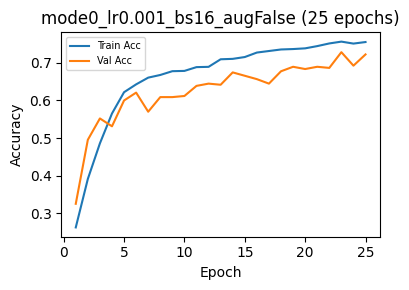

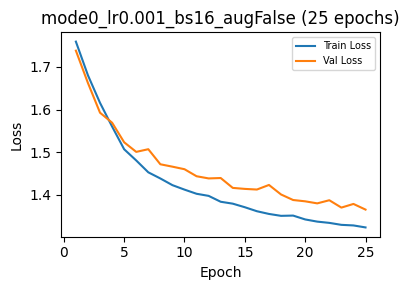

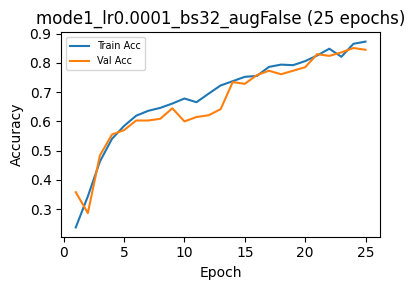

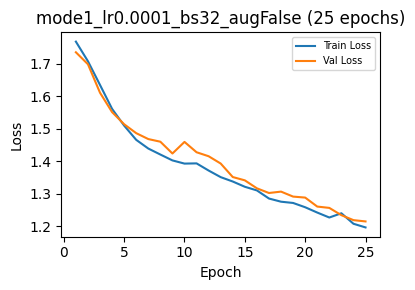

In [ ]:
import os
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ── A) Reuse SpecAugment & Dataset definitions from before ─────────────────

def spec_augment(spec: np.ndarray,
                 time_mask_pct: float = 0.10,
                 freq_mask_pct: float = 0.10) -> np.ndarray:
    H, W = spec.shape
    n_freq = int(H * freq_mask_pct)
    if n_freq > 0:
        f0 = np.random.randint(0, H - n_freq + 1)
        spec[f0 : f0 + n_freq, :] = -80.0
    n_time = int(W * time_mask_pct)
    if n_time > 0:
        t0 = np.random.randint(0, W - n_time + 1)
        spec[:, t0 : t0 + n_time] = -80.0
    return spec

class AugmentedMelDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, augment: bool = False):
        assert X.ndim == 4 and X.shape[1] == 1 and X.shape[2] == 64 and X.shape[3] == 225
        self.X = X
        self.y = y
        self.N = X.shape[0]
        self.augment = augment

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        spec_db = self.X[idx, 0].cpu().numpy().copy()
        if self.augment and (np.random.rand() < 0.5):
            spec_db = spec_augment(spec_db, 0.10, 0.10)
        x = torch.from_numpy(spec_db.astype(np.float32)).unsqueeze(0)
        y = torch.tensor(int(self.y[idx].item()), dtype=torch.long)
        return x, y

# ── B) Reuse Freeze‐unfreeze + model builder ─────────────────────────────────

import onnx
from onnx2pytorch import ConvertModel

onnx_path = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/ToneNet_Models/tonenet.onnx"
onnx_model = onnx.load(onnx_path)

def make_tonenet():
    base = ConvertModel(onnx_model, experimental=True)
    base.eval()
    def replace_last_linear(m):
        for name, child in m.named_children():
            if isinstance(child, nn.Linear) and child.out_features == 4:
                new_head = nn.Linear(child.in_features, 6)
                setattr(m, name, new_head)
                return True
            else:
                if replace_last_linear(child):
                    return True
        return False
    assert replace_last_linear(base)
    return base

def set_freeze(model, mode):
    for param in model.parameters():
        param.requires_grad = False
    if mode >= 1:
        for name, param in model.named_parameters():
            if ("dense_1" in name) or ("dense_2" in name) or ("dense_3" in name):
                param.requires_grad = True
    if mode >= 2:
        for name, param in model.named_parameters():
            if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
                param.requires_grad = True
    if mode >= 3:
        for name, param in model.named_parameters():
            if "conv2d_" in name or "batch_normalization_" in name or "activation_" in name:
                param.requires_grad = True
    if mode == 0:
        for name, param in model.named_parameters():
            if "dense_3" in name:
                param.requires_grad = True

# ── C) Load your combined data & Forvo set ──────────────────────────────────

combined_pkg_small = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/combined_package_small"
X_full = np.load(f"{combined_pkg_small}/X_full.npy")   # (N,1,64,225)
y_full = np.load(f"{combined_pkg_small}/y_full.npy")   # (N,)
X_tensor = torch.tensor(X_full, dtype=torch.float32)
y_tensor = torch.tensor(y_full, dtype=torch.long)

# Same train/val/test split indices used before:
N       = len(X_tensor)
train_n = int(0.8 * N)
val_n   = int(0.1 * N)
test_n  = N - train_n - val_n
indices = list(range(N))
from torch.utils.data import random_split
train_indices, val_indices, test_indices = random_split(
    indices, [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

# Forvo
forvo_pkg = "/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/forvo_syllables"
X_forvo = np.load(f"{forvo_pkg}/X.npy")
y_forvo = np.load(f"{forvo_pkg}/y.npy")
ds_forvo = TensorDataset(
    torch.tensor(X_forvo, dtype=torch.float32),
    torch.tensor(y_forvo, dtype=torch.long)
)
forvo_loader = DataLoader(ds_forvo, batch_size=16, shuffle=False, pin_memory=True)

# ── D) Read previous grid‐search results to pick top configs ────────────────

results_df = pd.read_csv("/content/drive/MyDrive/UPF_Deep_Learning_2025/Project/experiment_results/grid_results_with_val.csv")

# Option 1: pick top 3 by Forvo Acc
top3_forvo = results_df.sort_values("forvo_acc", ascending=False).head(10)["config"].tolist()

# Option 2: pick top 3 by Val Acc (uncomment if you prefer)
# top3_forvo = results_df.sort_values("val_acc", ascending=False).head(3)["config"].tolist()

print("Retraining these configs for 25 epochs:", top3_forvo)

# ── E) Utility: parse a config string back into its parameters ─────────────
def parse_config(cfg_str):
    # Example format: "mode2_lr0.0001_bs16_augTrue"
    parts = cfg_str.split("_")
    mode     = int(parts[0].replace("mode",""))
    lr       = float(parts[1].replace("lr",""))
    bs       = int(parts[2].replace("bs",""))
    augment  = parts[3].replace("aug","") == "True"
    return mode, lr, bs, augment

# ── F) Loop over top configs and retrain for 25 epochs ─────────────────────

extended_results = []
extended_histories = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 25

for cfg in top3_forvo:
    mode, lr, bs, augment_flag = parse_config(cfg)
    print(f"\n=== Running {cfg} for {num_epochs} epochs ===")

    # 1) Build model & freeze/unfreeze
    model = make_tonenet().to(device)
    set_freeze(model, mode)

    # 2) Group parameters for discriminative LR
    conv5_params = []
    dense1and2_params = []
    new_head_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        if ("conv2d_5" in name) or ("batch_normalization_5" in name) or ("activation_5" in name):
            conv5_params.append(param)
        elif ("dense_1" in name) or ("dense_2" in name):
            dense1and2_params.append(param)
        elif "dense_3" in name:
            new_head_params.append(param)

    param_groups = []
    if mode >= 2 and conv5_params:
        param_groups.append({"params": conv5_params,      "lr": lr * 0.1})
    if mode >= 1 and dense1and2_params:
        param_groups.append({"params": dense1and2_params, "lr": lr * 0.5})
    if new_head_params:
        param_groups.append({"params": new_head_params,   "lr": lr})

    optimizer = torch.optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()

    # 3) Create Datasets & DataLoaders
    full_dataset = AugmentedMelDataset(X_tensor, y_tensor, augment=augment_flag)
    train_ds = torch.utils.data.Subset(full_dataset, train_indices)
    val_ds   = torch.utils.data.Subset(full_dataset, val_indices)
    test_ds  = torch.utils.data.Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, pin_memory=True)

    # 4) Placeholders for metrics
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    # 5) Training loop
    for epoch in range(num_epochs):
        model.train()
        tot, corr, loss_sum = 0, 0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            xb_nhwc = batch_to_nhwc_rgb(xb)
            logits = model(xb_nhwc)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds = logits.argmax(dim=1)
                corr += (preds == yb).sum().item()
                tot  += yb.size(0)
                loss_sum += loss.item() * yb.size(0)

        epoch_train_acc  = corr / tot
        epoch_train_loss = loss_sum / tot
        train_accs.append(epoch_train_acc)
        train_losses.append(epoch_train_loss)

        model.eval()
        v_corr, v_tot, v_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                xb_nhwc = batch_to_nhwc_rgb(xb)
                logits = model(xb_nhwc)
                loss   = criterion(logits, yb)
                preds  = logits.argmax(dim=1)
                v_corr   += (preds == yb).sum().item()
                v_tot    += yb.size(0)
                v_loss_sum += loss.item() * yb.size(0)

        epoch_val_acc  = v_corr / v_tot
        epoch_val_loss = v_loss_sum / v_tot
        val_accs.append(epoch_val_acc)
        val_losses.append(epoch_val_loss)

        if epoch == num_epochs - 1:
            print(f"→ Final Epoch: train_acc={epoch_train_acc:.3f}, val_acc={epoch_val_acc:.3f}")

    # 6) Test on held‐out synthetic+drill
    model.eval()
    t_corr, t_tot = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_nhwc = batch_to_nhwc_rgb(xb)
            preds = model(xb_nhwc).argmax(dim=1)
            t_corr += (preds == yb).sum().item()
            t_tot  += yb.size(0)
    test_acc = t_corr / t_tot

    # 7) Evaluate on Forvo
    forvo_corr, forvo_tot = 0, 0
    with torch.no_grad():
        for xb, yb in forvo_loader:
            xb, yb = xb.to(device), yb.to(device)
            # Convert batch (N,1,64,225) → (N,1,64,225) but we expect (1,64,225) input already
            # AugmentedMelDataset returns (1,64,225). Here, forvo_loader yields (1,64,225).
            # ToneNet expects NHWC (225×225×3), so we need to resize & replicate:
            B = xb.shape[0]
            x_nhwc = torch.zeros((B, 225, 225, 3), dtype=torch.float32, device=device)
            xb_np = xb.cpu().numpy()
            for i in range(B):
                spec_db = xb_np[i, 0].clip(-80.0, 0.0)
                spec_resized = cv2.resize(spec_db, (225,225), interpolation=cv2.INTER_LINEAR)
                nhwc = np.stack([spec_resized]*3, axis=-1)
                x_nhwc[i] = torch.from_numpy(nhwc.astype(np.float32)).to(device)

            preds = model(x_nhwc).argmax(dim=1)
            forvo_corr += (preds == yb).sum().item()
            forvo_tot  += yb.size(0)
    forvo_acc = forvo_corr / forvo_tot

    # 8) Record results & histories
    extended_results.append({
        "config":    cfg,
        "freeze_mode": mode,
        "lr":        lr,
        "batch_size": bs,
        "augment":   augment_flag,
        "test_acc":  test_acc,
        "forvo_acc": forvo_acc
    })
    extended_histories[cfg] = {
        "train_losses": train_losses,
        "train_accs":   train_accs,
        "val_losses":   val_losses,
        "val_accs":     val_accs
    }

    # 9) Save the fine‐tuned model weights for this config (optional)
    output_wts = os.path.join(save_dir, f"{cfg}_25epoch.pth")
    torch.save(model.state_dict(), output_wts)
    print(f"Saved 25‐epoch weights to {output_wts}\n")

# ── G) Save extended results and histories ─────────────────────────────────
ext_df = pd.DataFrame(extended_results)
ext_df.to_csv(os.path.join(save_dir, "extended_top3_results.csv"), index=False)
with open(os.path.join(save_dir, "extended_histories.pkl"), "wb") as f:
    pickle.dump(extended_histories, f)
print("Extended runs complete. Results saved to extended_top3_results.csv.")

# ── H) Plot the new, longer curves for each top‐3 config ────────────────────
for cfg in top3_forvo:
    hist = extended_histories[cfg]
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(4,3))
    plt.plot(epochs, hist["train_accs"], label="Train Acc")
    plt.plot(epochs, hist["val_accs"],   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{cfg} (25 epochs)")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,3))
    plt.plot(epochs, hist["train_losses"], label="Train Loss")
    plt.plot(epochs, hist["val_losses"],   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{cfg} (25 epochs)")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# ── A) Point these to your actual paths ────────────────────────
results_csv   = local_data_root+"experiment_results/extended_top3_results.csv"
histories_pkl = local_data_root+"experiment_results/extended_histories.pkl"

# ── B) Load them ───────────────────────────────────────────────
df10 = pd.read_csv(results_csv)

with open(histories_pkl, "rb") as f:
    all_histories10 = pickle.load(f)
    # all_histories10 should be a dict: { config_str → { "train_losses": [...], "train_accs": [...], "val_losses": [...], "val_accs": [...] } }


In [ ]:
# Add a column “rank_forvo” to see top models by Forvo Acc (descending)
df10["rank_test"] = df10["test_acc"].rank(method="first", ascending=False).astype(int)

# Sort by descending Forvo
df10_sorted = df10.sort_values("test_acc", ascending=False).reset_index(drop=True)

df10_sorted

,config,freeze_mode,lr,batch_size,augment,test_acc,forvo_acc,rank_forvo,rank_test
0,mode3_lr0.0001_bs16_augFalse,3,0.0001,16,False,0.908012,0.384615,4,1
1,mode1_lr0.0001_bs32_augFalse,1,0.0001,32,False,0.869436,0.250000,10,2
2,mode3_lr0.0001_bs16_augTrue,3,0.0001,16,True,0.842730,0.326923,8,3
3,mode2_lr0.0001_bs16_augFalse,2,0.0001,16,False,0.786350,0.365385,6,4
4,mode2_lr0.0001_bs32_augFalse,2,0.0001,32,False,0.783383,0.423077,1,5
5,mode0_lr0.001_bs16_augFalse,0,0.0010,16,False,0.774481,0.326923,9,6
6,mode2_lr0.0001_bs32_augTrue,2,0.0001,32,True,0.750742,0.403846,3,7
7,mode1_lr0.0001_bs32_augTrue,1,0.0001,32,True,0.727003,0.365385,5,8
8,mode1_lr0.0001_bs16_augTrue,1,0.0001,16,True,0.721068,0.326923,7,9
9,mode0_lr0.001_bs32_augFalse,0,0.0010,32,False,0.661721,0.403846,2,10


In [ ]:
top3 = df10_sorted.head(3)
print("Top-3 models by Forvo accuracy:\n")
print(top3[["config","freeze_mode","lr","batch_size","augment","test_acc","forvo_acc"]].to_string(index=False))


Top-3 models by Forvo accuracy:

                      config  freeze_mode     lr  batch_size  augment  test_acc  forvo_acc
mode3_lr0.0001_bs16_augFalse            3 0.0001          16    False  0.908012   0.384615
mode1_lr0.0001_bs32_augFalse            1 0.0001          32    False  0.869436   0.250000
 mode3_lr0.0001_bs16_augTrue            3 0.0001          16     True  0.842730   0.326923


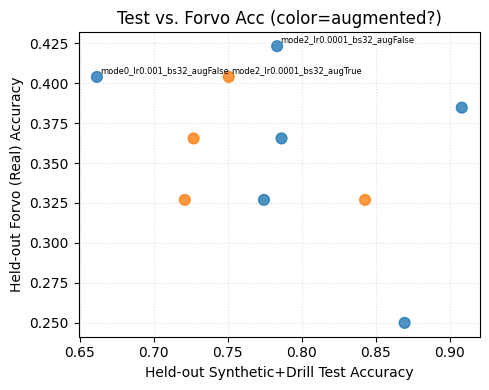

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(df10["test_acc"], df10["forvo_acc"],
            c=df10["augment"].map({True:"C1", False:"C0"}),
            s=60, alpha=0.8)

for i,row in df10.iterrows():
    if row["rank_forvo"] <= 3:
        # annotate the top-3 points
        plt.text(row["test_acc"]+0.002, row["forvo_acc"]+0.002,
                 row["config"], fontsize=6)

plt.xlabel("Held-out Synthetic+Drill Test Accuracy")
plt.ylabel("Held-out Forvo (Real) Accuracy")
plt.title("Test vs. Forvo Acc (color=augmented?)")
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
best_cfg = df10_sorted.iloc[0]["config"]
print("Best config:", best_cfg)


Best config: mode3_lr0.0001_bs16_augFalse


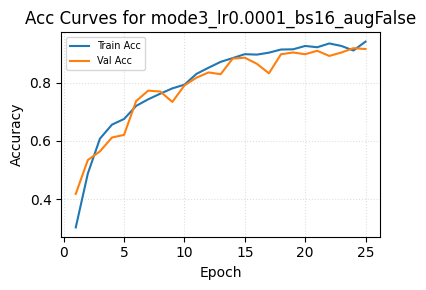

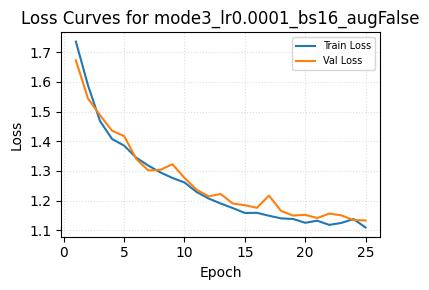

In [ ]:
hist = all_histories10[best_cfg]
epochs = list(range(1, len(hist["train_accs"])+1))

plt.figure(figsize=(4,3))
plt.plot(epochs, hist["train_accs"], label="Train Acc")
plt.plot(epochs, hist["val_accs"],   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Acc Curves for {best_cfg}")
plt.legend(fontsize=7)
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.plot(epochs, hist["train_losses"], label="Train Loss")
plt.plot(epochs, hist["val_losses"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curves for {best_cfg}")
plt.legend(fontsize=7)
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

# (Rebuild the “best” model, load its weights, and create a DataLoader for your Forvo set.)
# Let’s assume we have a helper to rebuild/load:

def load_best_model(cfg: str):
    mode, lr, bs, augment_flag = parse_config(cfg)
    m = make_tonenet().to(device)
    set_freeze(m, mode)
    # load weights from disk—whatever path you used. For example:
    wts_path = f"{save_dir}/{cfg}_25epoch.pth"
    m.load_state_dict(torch.load(wts_path, map_location=device))
    m.eval()
    return m

best_model = load_best_model(best_cfg)

all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in forvo_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb_nhwc = batch_to_nhwc_rgb(xb)
        logits  = best_model(xb_nhwc)
        preds   = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())

with open(f"{combined_pkg_small}/label_names.json", "r", encoding="utf-8") as f:
    label_names = json.load(f)

print("Classification report (Forvo):\n")
print(classification_report(all_true, all_preds, target_names=label_names))

cm = confusion_matrix(all_true, all_preds)
print("Confusion matrix (Forvo):")
print(cm)


NameError: name 'parse_config' is not defined